<a href="https://colab.research.google.com/github/butler-julie/GDSVirtualTutorials/blob/main/072525_DecisionMaking/GDS_1_GP_%26_sGP_BO_BoTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Gaussian process-based Bayesian optimization

- Rewritten in Gpytorch and Botorch by [Utkarsh Pratiush](https://github.com/utkarshp1161). [Originally in Gpax](https://github.com/SergeiVKalinin/ACerS_AE_2024/blob/main/1_GPax_GP_BO.ipynb) by [Maxim Ziatdinov](https://github.com/ziatdinovmax) and [SVK](https://github.com/SergeiVKalinin).


## 1a. Install dependecies

In [ ]:
!pip install -q botorch==0.12.0
!pip install -q gpytorch==1.13

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 1b. Kernels in Gpytorch
It can be tricky to define them from scratch as done below but off the shelf kernels can be directly used as well
- from gpytorch.kernels import RBFKernel, ScaleKernel, MaternKernel
- see https://docs.gpytorch.ai/en/latest/kernels.html



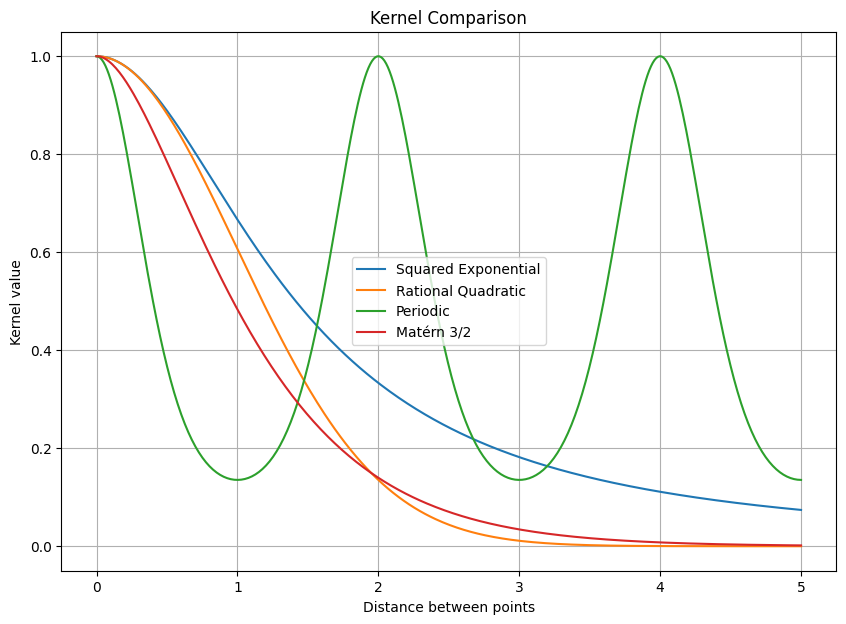

In [ ]:
import torch
import matplotlib.pyplot as plt
import gpytorch
from gpytorch.constraints import Positive
import math

class SquaredExponentialKernel(gpytorch.kernels.Kernel):
    is_stationary = True

    def __init__(self, variance_prior=None, length_prior=None,
                 variance_constraint=None, length_constraint=None, **kwargs):
        super().__init__(**kwargs)

        # Register raw parameters
        self.register_parameter(
            name='raw_length',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )
        self.register_parameter(
            name='raw_variance',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )

        # Set constraints
        if length_constraint is None:
            length_constraint = Positive()
        if variance_constraint is None:
            variance_constraint = Positive()

        self.register_constraint("raw_length", length_constraint)
        self.register_constraint("raw_variance", variance_constraint)

        # Set priors if any
        if length_prior is not None:
            self.register_prior(
                "length_prior",
                length_prior,
                lambda m: m.length,
                lambda m, v: m._set_length(v),
            )
        if variance_prior is not None:
            self.register_prior(
                "variance_prior",
                variance_prior,
                lambda m: m.variance,
                lambda m, v: m._set_variance(v),
            )

    # Length scale property
    @property
    def length(self):
        return self.raw_length_constraint.transform(self.raw_length)

    @length.setter
    def length(self, value):
        return self._set_length(value)

    def _set_length(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_length)
        self.initialize(raw_length=self.raw_length_constraint.inverse_transform(value))

    # Variance property
    @property
    def variance(self):
        return self.raw_variance_constraint.transform(self.raw_variance)

    @variance.setter
    def variance(self, value):
        return self._set_variance(value)

    def _set_variance(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_variance)
        self.initialize(raw_variance=self.raw_variance_constraint.inverse_transform(value))

    def forward(self, x1, x2, **params):
        # Scale by length
        x1_ = x1.div(self.length)
        x2_ = x2.div(self.length)

        # Compute squared distance
        squared_dist = self.covar_dist(x1_, x2_, **params).pow(2)

        # Compute kernel
        return self.variance * torch.exp(-0.5 * squared_dist)
class RationalQuadraticKernel(gpytorch.kernels.Kernel):
    is_stationary = True

    def __init__(self, variance_prior=None, length_prior=None, alpha_prior=None,
                 variance_constraint=None, length_constraint=None, alpha_constraint=None, **kwargs):
        super().__init__(**kwargs)

        # Register raw parameters
        self.register_parameter(
            name='raw_length',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )
        self.register_parameter(
            name='raw_variance',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )
        self.register_parameter(
            name='raw_alpha',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )

        # Set constraints
        if length_constraint is None:
            length_constraint = Positive()
        if variance_constraint is None:
            variance_constraint = Positive()
        if alpha_constraint is None:
            alpha_constraint = Positive()

        self.register_constraint("raw_length", length_constraint)
        self.register_constraint("raw_variance", variance_constraint)
        self.register_constraint("raw_alpha", alpha_constraint)

        # Set priors if any
        if length_prior is not None:
            self.register_prior(
                "length_prior",
                length_prior,
                lambda m: m.length,
                lambda m, v: m._set_length(v),
            )
        if variance_prior is not None:
            self.register_prior(
                "variance_prior",
                variance_prior,
                lambda m: m.variance,
                lambda m, v: m._set_variance(v),
            )
        if alpha_prior is not None:
            self.register_prior(
                "alpha_prior",
                alpha_prior,
                lambda m: m.alpha,
                lambda m, v: m._set_alpha(v),
            )

    # Length scale property
    @property
    def length(self):
        return self.raw_length_constraint.transform(self.raw_length)

    @length.setter
    def length(self, value):
        return self._set_length(value)

    def _set_length(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_length)
        self.initialize(raw_length=self.raw_length_constraint.inverse_transform(value))

    # Variance property
    @property
    def variance(self):
        return self.raw_variance_constraint.transform(self.raw_variance)

    @variance.setter
    def variance(self, value):
        return self._set_variance(value)

    def _set_variance(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_variance)
        self.initialize(raw_variance=self.raw_variance_constraint.inverse_transform(value))

    # Alpha property
    @property
    def alpha(self):
        return self.raw_alpha_constraint.transform(self.raw_alpha)

    @alpha.setter
    def alpha(self, value):
        return self._set_alpha(value)

    def _set_alpha(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_alpha)
        self.initialize(raw_alpha=self.raw_alpha_constraint.inverse_transform(value))

    def forward(self, x1, x2, **params):
        # Compute squared distance
        squared_dist = self.covar_dist(x1, x2, **params).pow(2)

        # Compute kernel
        return self.variance * (1 + squared_dist / (2 * self.alpha * self.length**2))**(-self.alpha)
class PeriodicKernel(gpytorch.kernels.Kernel):
    is_stationary = True

    def __init__(self, variance_prior=None, length_prior=None, period_prior=None,
                 variance_constraint=None, length_constraint=None, period_constraint=None, **kwargs):
        super().__init__(**kwargs)

        # Register raw parameters
        self.register_parameter(
            name='raw_length',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )
        self.register_parameter(
            name='raw_variance',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )
        self.register_parameter(
            name='raw_period',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )

        # Set constraints
        if length_constraint is None:
            length_constraint = Positive()
        if variance_constraint is None:
            variance_constraint = Positive()
        if period_constraint is None:
            period_constraint = Positive()

        self.register_constraint("raw_length", length_constraint)
        self.register_constraint("raw_variance", variance_constraint)
        self.register_constraint("raw_period", period_constraint)

        # Set priors if any
        if length_prior is not None:
            self.register_prior(
                "length_prior",
                length_prior,
                lambda m: m.length,
                lambda m, v: m._set_length(v),
            )
        if variance_prior is not None:
            self.register_prior(
                "variance_prior",
                variance_prior,
                lambda m: m.variance,
                lambda m, v: m._set_variance(v),
            )
        if period_prior is not None:
            self.register_prior(
                "period_prior",
                period_prior,
                lambda m: m.period,
                lambda m, v: m._set_period(v),
            )

    # Length scale property
    @property
    def length(self):
        return self.raw_length_constraint.transform(self.raw_length)

    @length.setter
    def length(self, value):
        return self._set_length(value)

    def _set_length(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_length)
        self.initialize(raw_length=self.raw_length_constraint.inverse_transform(value))

    # Variance property
    @property
    def variance(self):
        return self.raw_variance_constraint.transform(self.raw_variance)

    @variance.setter
    def variance(self, value):
        return self._set_variance(value)

    def _set_variance(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_variance)
        self.initialize(raw_variance=self.raw_variance_constraint.inverse_transform(value))

    # Period property
    @property
    def period(self):
        return self.raw_period_constraint.transform(self.raw_period)

    @period.setter
    def period(self, value):
        return self._set_period(value)

    def _set_period(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_period)
        self.initialize(raw_period=self.raw_period_constraint.inverse_transform(value))

    def forward(self, x1, x2, **params):
        # Compute distance
        dist = self.covar_dist(x1, x2, **params)

        # Compute periodic kernel
        sin_component = torch.sin(math.pi * dist / self.period)
        exp_component = -2 * sin_component.pow(2) / self.length.pow(2)

        return self.variance * torch.exp(exp_component)
class MaternKernel(gpytorch.kernels.Kernel):
    is_stationary = True

    def __init__(self, variance_prior=None, length_prior=None,
                 variance_constraint=None, length_constraint=None, **kwargs):
        super().__init__(**kwargs)

        # Register raw parameters
        self.register_parameter(
            name='raw_length',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )
        self.register_parameter(
            name='raw_variance',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )

        # Set constraints
        if length_constraint is None:
            length_constraint = Positive()
        if variance_constraint is None:
            variance_constraint = Positive()

        self.register_constraint("raw_length", length_constraint)
        self.register_constraint("raw_variance", variance_constraint)

        # Set priors if any
        if length_prior is not None:
            self.register_prior(
                "length_prior",
                length_prior,
                lambda m: m.length,
                lambda m, v: m._set_length(v),
            )
        if variance_prior is not None:
            self.register_prior(
                "variance_prior",
                variance_prior,
                lambda m: m.variance,
                lambda m, v: m._set_variance(v),
            )

    # Length scale property
    @property
    def length(self):
        return self.raw_length_constraint.transform(self.raw_length)

    @length.setter
    def length(self, value):
        return self._set_length(value)

    def _set_length(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_length)
        self.initialize(raw_length=self.raw_length_constraint.inverse_transform(value))

    # Variance property
    @property
    def variance(self):
        return self.raw_variance_constraint.transform(self.raw_variance)

    @variance.setter
    def variance(self, value):
        return self._set_variance(value)

    def _set_variance(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_variance)
        self.initialize(raw_variance=self.raw_variance_constraint.inverse_transform(value))

    def forward(self, x1, x2, **params):
        # Compute distance
        dist = self.covar_dist(x1, x2, **params)

        # Scale by length
        scaled_dist = dist.div(self.length)

        # Compute Matern kernel (nu=3/2)
        sqrt3 = torch.sqrt(torch.tensor(3.0))
        return self.variance * (1 + sqrt3 * scaled_dist) * torch.exp(-sqrt3 * scaled_dist)

# Create kernel instances
rq_kernel = RationalQuadraticKernel()
se_kernel = SquaredExponentialKernel()
pe_kernel = PeriodicKernel()
mt_kernel = MaternKernel()

# Set parameters
rq_kernel.length = 1.0
rq_kernel.variance = 1.0
rq_kernel.alpha = 1.0

se_kernel.length = 1.0
se_kernel.variance = 1.0

pe_kernel.length = 1.0
pe_kernel.variance = 1.0
pe_kernel.period = 2.0

mt_kernel.length = 1.0
mt_kernel.variance = 1.0

# Create distance matrix
d = torch.linspace(0, 5, 400)#.view(-1, 1)
zeros = torch.zeros_like(d)

# Compute kernel values
K_RQ = rq_kernel(d, zeros).evaluate().squeeze()
K_SE = se_kernel(d, zeros).evaluate().squeeze()
K_periodic = pe_kernel(d, zeros).evaluate().squeeze()
K_Matern = mt_kernel(d, zeros).evaluate().squeeze()


# Plot
plt.figure(figsize=(10, 7))
# plot self terms - diagonal enteries
plt.plot(d.numpy(), K_RQ.detach().numpy().diagonal(), label='Squared Exponential')
plt.plot(d.numpy(), K_SE.detach().numpy().diagonal(), label='Rational Quadratic')
plt.plot(d.numpy(), K_periodic.detach().numpy().diagonal(), label='Periodic')
plt.plot(d.numpy(), K_Matern.detach().numpy().diagonal(), label='Matérn 3/2')

plt.title('Kernel Comparison')
plt.xlabel('Distance between points')
plt.ylabel('Kernel value')
plt.legend()
plt.grid(True)
plt.show()


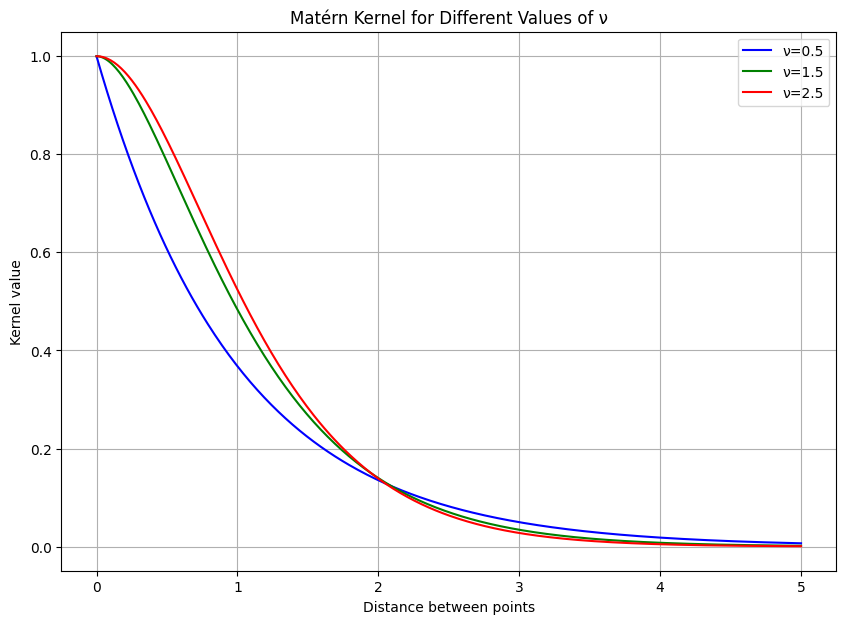

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv, gamma

class MaternKernel(gpytorch.kernels.Kernel):
    is_stationary = True

    def __init__(self, nu=1.5, variance_prior=None, length_prior=None,
                 variance_constraint=None, length_constraint=None, **kwargs):
        super().__init__(**kwargs)

        self.nu = nu

        # Register raw parameters
        self.register_parameter(
            name='raw_length',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )
        self.register_parameter(
            name='raw_variance',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )

        # Set constraints
        if length_constraint is None:
            length_constraint = Positive()
        if variance_constraint is None:
            variance_constraint = Positive()

        self.register_constraint("raw_length", length_constraint)
        self.register_constraint("raw_variance", variance_constraint)

        # Set priors if any
        if length_prior is not None:
            self.register_prior(
                "length_prior",
                length_prior,
                lambda m: m.length,
                lambda m, v: m._set_length(v),
            )
        if variance_prior is not None:
            self.register_prior(
                "variance_prior",
                variance_prior,
                lambda m: m.variance,
                lambda m, v: m._set_variance(v),
            )

    @property
    def length(self):
        return self.raw_length_constraint.transform(self.raw_length)

    @length.setter
    def length(self, value):
        return self._set_length(value)

    def _set_length(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_length)
        self.initialize(raw_length=self.raw_length_constraint.inverse_transform(value))

    @property
    def variance(self):
        return self.raw_variance_constraint.transform(self.raw_variance)

    @variance.setter
    def variance(self, value):
        return self._set_variance(value)

    def _set_variance(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_variance)
        self.initialize(raw_variance=self.raw_variance_constraint.inverse_transform(value))

    def forward(self, x1, x2, **params):
        distance = self.covar_dist(x1.div(self.length), x2.div(self.length), **params)

        # Handle the zero distance case
        eps = 1e-10
        distance = distance.clamp(min=eps)

        if self.nu == 0.5:
            K = torch.exp(-distance)
        elif self.nu == 1.5:
            K = (1 + math.sqrt(3) * distance) * torch.exp(-math.sqrt(3) * distance)
        elif self.nu == 2.5:
            K = (1 + math.sqrt(5) * distance + 5/3 * distance**2) * torch.exp(-math.sqrt(5) * distance)
        else:
            raise ValueError("Only nu=0.5, 1.5, and 2.5 are supported")

        return self.variance * K

# Settings for different ν values
# Create different Matérn kernels
kernel_05 = MaternKernel(nu=0.5)
kernel_15 = MaternKernel(nu=1.5)
kernel_25 = MaternKernel(nu=2.5)

# Set parameters
for kernel in [kernel_05, kernel_15, kernel_25]:
    kernel.length = 1.0
    kernel.variance = 1.0

# Create distance matrix
d = torch.linspace(0, 5, 400).view(-1, 1)
zeros = torch.zeros_like(d)
# Compute kernel values
K_05 = kernel_05(d, zeros).evaluate().squeeze()
K_15 = kernel_15(d, zeros).evaluate().squeeze()
K_25 = kernel_25(d, zeros).evaluate().squeeze()

# Plot
plt.figure(figsize=(10, 7))
plt.plot(d.numpy(), K_05.detach().numpy().diagonal() , c = "b", label='ν=0.5')
plt.plot(d.numpy(), K_15.detach().numpy().diagonal() , c = "g", label='ν=1.5')
plt.plot(d.numpy(), K_25.detach().numpy().diagonal() , c = "r", label='ν=2.5')
plt.title('Matérn Kernel for Different Values of ν')
plt.xlabel('Distance between points')
plt.ylabel('Kernel value')
plt.legend()
plt.grid(True)
plt.show()




## 1c. GPs for different kernels

/tmp/ipython-input-4-4123652268.py:12: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples_SE = np.random.multivariate_normal(mean=np.zeros(X.shape[0]), cov=K_SE, size=3)
/tmp/ipython-input-4-4123652268.py:13: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples_RQ = np.random.multivariate_normal(mean=np.zeros(X.shape[0]), cov=K_RQ, size=3)
/tmp/ipython-input-4-4123652268.py:14: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples_P = np.random.multivariate_normal(mean=np.zeros(X.shape[0]), cov=K_P, size=3)
/tmp/ipython-input-4-4123652268.py:15: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples_M = np.random.multivariate_normal(mean=np.zeros(X.shape[0]), cov=K_M, size=3)  # Samples for Matérn kernel


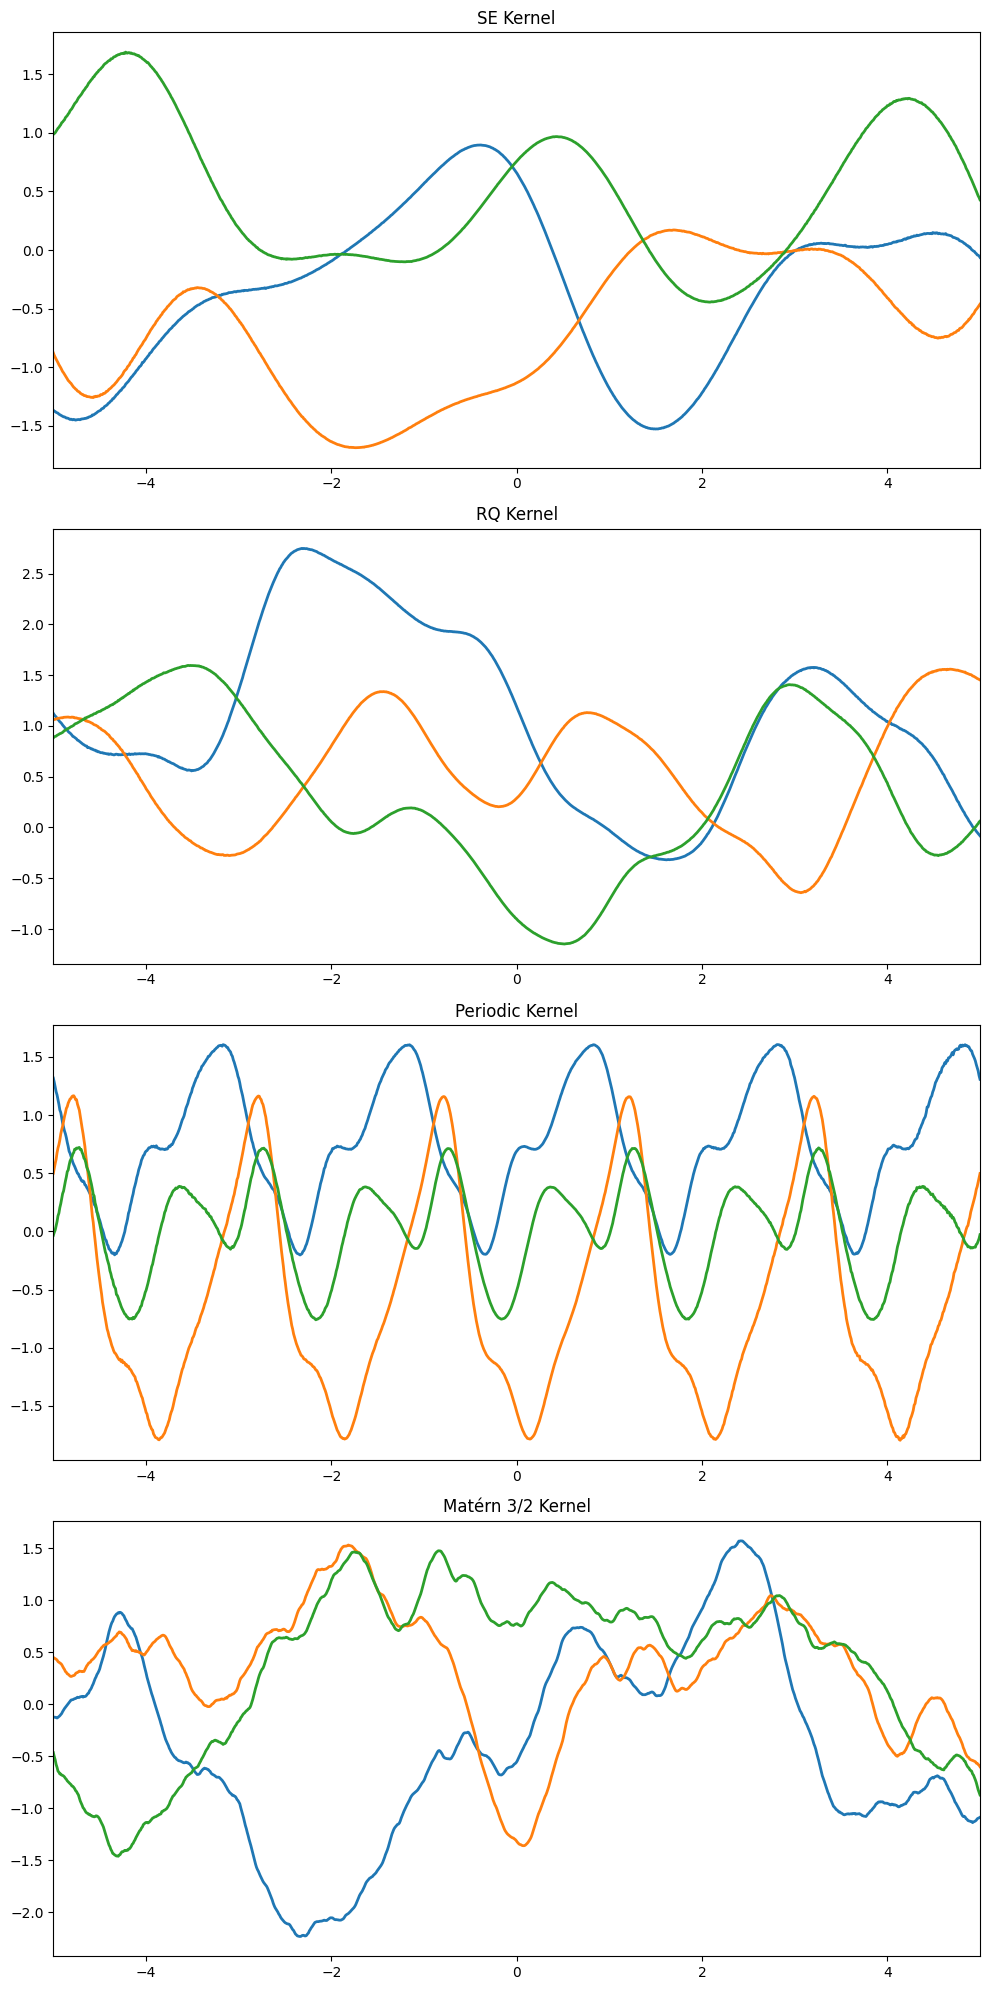

In [ ]:
# Generate data
X = torch.linspace(-5, 5, 1000).view(-1, 1)

# Compute kernel matrices
K_SE = se_kernel(X, X).evaluate().squeeze().detach().numpy()
K_RQ = rq_kernel(X, X).evaluate().squeeze().detach().numpy()
K_P = pe_kernel(X, X).evaluate().squeeze().detach().numpy()
K_M = mt_kernel(X, X) .evaluate().squeeze().detach().numpy() # Matérn kernel

# Drawing samples from the GP prior
np.random.seed(42)  # For reproducibility
samples_SE = np.random.multivariate_normal(mean=np.zeros(X.shape[0]), cov=K_SE, size=3)
samples_RQ = np.random.multivariate_normal(mean=np.zeros(X.shape[0]), cov=K_RQ, size=3)
samples_P = np.random.multivariate_normal(mean=np.zeros(X.shape[0]), cov=K_P, size=3)
samples_M = np.random.multivariate_normal(mean=np.zeros(X.shape[0]), cov=K_M, size=3)  # Samples for Matérn kernel

# Plotting
fig, axs = plt.subplots(4, 1, figsize=(10, 20))  # Adjusted for an additional row

for ax, samples, title in zip(axs, [samples_SE, samples_RQ, samples_P, samples_M], ['SE Kernel', 'RQ Kernel', 'Periodic Kernel', 'Matérn 3/2 Kernel']):
    for i in range(samples.shape[0]):
        ax.plot(X, samples[i], lw=2)
    ax.set_title(title)
    ax.set_xlim([-5, 5])

plt.tight_layout()
plt.show()


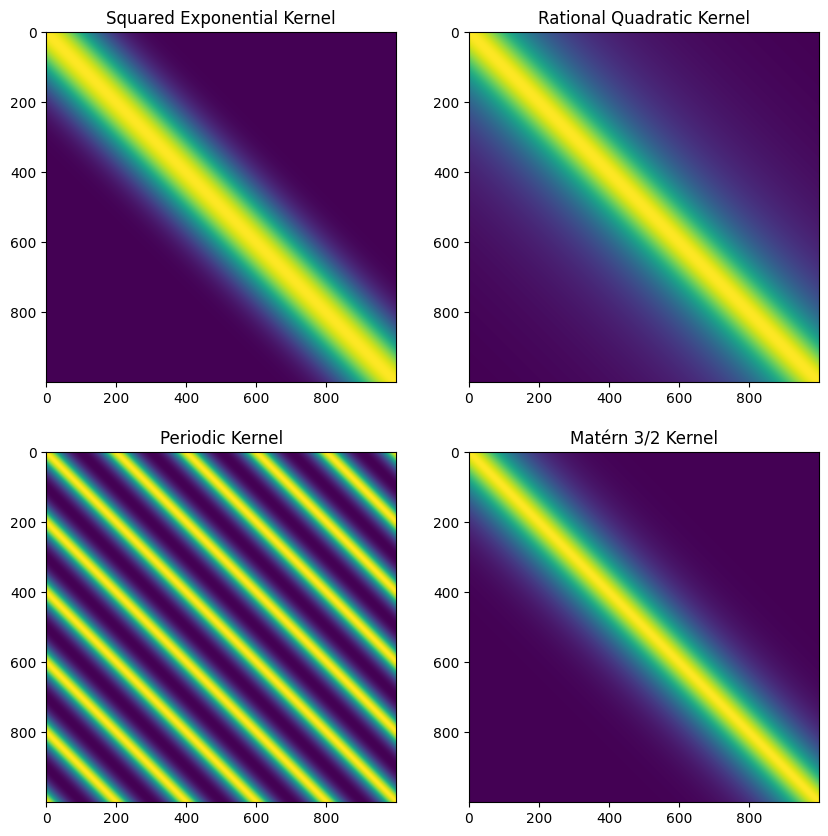

In [ ]:
import matplotlib.pyplot as plt

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot each kernel matrix as an imshow
axs[0, 0].imshow(K_SE)
axs[0, 0].set_title('Squared Exponential Kernel')
axs[0, 1].imshow(K_RQ)
axs[0, 1].set_title('Rational Quadratic Kernel')
axs[1, 0].imshow(K_P)
axs[1, 0].set_title('Periodic Kernel')
axs[1, 1].imshow(K_M)
axs[1, 1].set_title('Matérn 3/2 Kernel')

# Show the plot
plt.show()


## 1d. Define a data generation process (ground truth)

Let's define a function to be minimized and a function that emulates a noisy measurement:

SVK Note: Here, the function is ground truth. This is how nature behaves, but we do not know it. Purpose of the experiment is either learn this function (EU aquisition function), or discover minimum of this function (UCB aquisition function). Note that parameter beta in UCB determines balance between the explorationa and exploitation (if we set beta to zero, we make algorithm greedy so it get trapped into whatever minimum it discovers first). Also note that the noise that we add is a measurement noise that we define a priori. Experimentalist does not know what it is - you actually aim to learn it from the experiment.

In [ ]:
def func(x, y=1.2):
    out = (
        -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
        - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))
        + np.e + 20
    )
    return out

# Define measurement function that works with tensors
def measure(x, noise=0.01):
    """Measure function with noise that works with torch tensors"""
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.double)
    x = x.reshape(-1, 1)  # Ensure 2D tensor with shape (n, 1)

    # Add noise using torch operations
    noise = noise * torch.randn_like(x)#torch.randn_like(x)): Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1

    return func(x) + noise


Next, we generate a few noisy observations of our function. We also plot the true function ("ground truth") to confirm the location of the minimum at $x=0$ but we are not going to use it anywhere.

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))


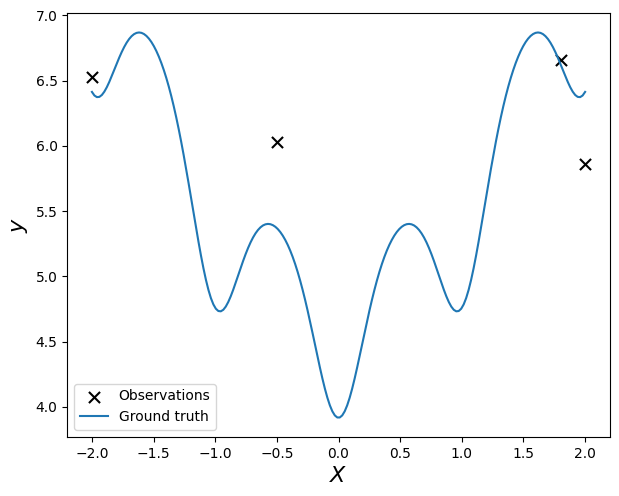

In [ ]:
np.random.seed(42)

X_bounds = np.array([-2, 2])
X = np.random.uniform(X_bounds[0], X_bounds[1], size=(2,))
X = np.append(X, X_bounds)
X = np.sort(X)
y = measure(X, noise = 0.3)

X_unmeasured = np.linspace(X_bounds[0], X_bounds[1], 200)
ground_truth = measure(X_unmeasured, noise=0)


_, ax = plt.subplots(dpi=100, figsize=(7, 5.5))
ax.set_xlabel("$X$", fontsize=16)
ax.set_ylabel("$y$", fontsize=16)
ax.scatter(X, y, marker='x', c='k', s=64, zorder=1, label="Observations", alpha=1.0)
ax.plot(X_unmeasured, ground_truth, label='Ground truth')
ax.legend(loc='best');

## 1e. Define Model

In [ ]:
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize, Normalize
# from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.kernels import  ScaleKernel

from gpytorch.constraints import GreaterThan

class CustomGP(SingleTaskGP):
    def __init__(self, train_X, train_Y, kernel, lengthscale_prior, outputscale_prior, noise_prior):
        super().__init__(
            train_X,
            train_Y,
            input_transform=Normalize(d=1),
            outcome_transform=Standardize(m=1)
        )
        self.mean_module.constant.requires_grad_(False)

        # Replace default kernel with custom kernel
        self.covar_module = ScaleKernel(kernel)
        """
        The ScaleKernel in this context serves as a wrapper around the base kernel
        and introduces an additional learned parameter called the "outputscale"
        """

        # Register priors
        self.covar_module.base_kernel.register_prior(
            "lengthscale_prior",
            lengthscale_prior,
            lambda module: module.lengthscale,
            lambda module, value: module._set_lengthscale(value)
        )

        self.covar_module.register_prior(
            "outputscale_prior",
            outputscale_prior,
            lambda module: module.outputscale
        )

        self.likelihood.register_prior(
            "noise_prior",
            noise_prior,
            lambda module: module.noise
        )

        self.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))


## 1f. Define Kernel's and Gaussian Process Priors

SVK note: Here, priors on noise and kernel length and scale are our best guesses before the experiment on how the measurement system behaves. Noise is combined effect of how precise are our measurements and how significant are other (uncontrollable) factors that affect the measurements. Kernel lengthscale is basically how rapidly we think the properties can change. Scale is simplest - it is just vertical scale. These guesses are very important - for example, if we think that our measurements are very precise (noise is small) but in reality noise is high, then algorithm will interpret each noise peak as as peak in ground truth (and can go horribly wrong by making kernel length very small). At the same time, if we set kernel length too large, it can never find small modulations in the function. Experiment with these paprameters! Noise in the ground truth vs. noise in the prior, and too big/too small kernel lengths.

Priors available to try in [GPyTorch](https://docs.gpytorch.ai/en/latest/priors.html)
   - GammaPrior
   - HalfCauchyPrior
   - LKJCovariancePrior
   - MultivariateNormalPrior
   - NormalPrior
   - LogNormalPrior
   - HalfNormalPrior
   - SmoothedBoxPrior
   - UniformPrior

Let's try GammaPrior

In [ ]:
### more kernel's to try
class RBFKernel(gpytorch.kernels.Kernel):
    is_stationary = True

    def __init__(self, variance_prior=None, length_prior=None,
                 variance_constraint=None, length_constraint=None, **kwargs):
        super().__init__(**kwargs)

        # Register raw parameters
        self.register_parameter(
            name='raw_lengthscale',  # Changed from raw_length to raw_lengthscale
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )
        self.register_parameter(
            name='raw_variance',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )

        # Set constraints
        if length_constraint is None:
            length_constraint = Positive()
        if variance_constraint is None:
            variance_constraint = Positive()

        self.register_constraint("raw_lengthscale", length_constraint)
        self.register_constraint("raw_variance", variance_constraint)

        # Set priors if any
        if length_prior is not None:
            self.register_prior(
                "lengthscale_prior",  # Changed from length_prior to lengthscale_prior
                length_prior,
                lambda m: m.lengthscale,  # Changed from length to lengthscale
                lambda m, v: m._set_lengthscale(v),  # Changed from _set_length
            )
        if variance_prior is not None:
            self.register_prior(
                "variance_prior",
                variance_prior,
                lambda m: m.variance,
                lambda m, v: m._set_variance(v),
            )

    # Lengthscale property
    @property
    def lengthscale(self):  # Changed from length to lengthscale
        return self.raw_lengthscale_constraint.transform(self.raw_lengthscale)

    @lengthscale.setter
    def lengthscale(self, value):
        return self._set_lengthscale(value)

    def _set_lengthscale(self, value):  # Changed from _set_length
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_lengthscale)
        self.initialize(raw_lengthscale=self.raw_lengthscale_constraint.inverse_transform(value))

    # Variance property
    @property
    def variance(self):
        return self.raw_variance_constraint.transform(self.raw_variance)

    @variance.setter
    def variance(self, value):
        return self._set_variance(value)

    def _set_variance(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_variance)
        self.initialize(raw_variance=self.raw_variance_constraint.inverse_transform(value))

    def forward(self, x1, x2, **params):
        dist = self.covar_dist(x1, x2, **params)
        scaled_dist = dist.div(self.lengthscale)
        return self.variance * torch.exp(-0.5 * scaled_dist.pow(2))

class Matern52Kernel(gpytorch.kernels.Kernel):
    is_stationary = True

    def __init__(self, variance_prior=None, length_prior=None,
                 variance_constraint=None, length_constraint=None, **kwargs):
        super().__init__(**kwargs)

        # Register raw parameters
        self.register_parameter(
            name='raw_lengthscale',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )
        self.register_parameter(
            name='raw_variance',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )

        # Set constraints
        if length_constraint is None:
            length_constraint = Positive()
        if variance_constraint is None:
            variance_constraint = Positive()

        self.register_constraint("raw_lengthscale", length_constraint)
        self.register_constraint("raw_variance", variance_constraint)

        # Set priors if any
        if length_prior is not None:
            self.register_prior(
                "lengthscale_prior",
                length_prior,
                lambda m: m.lengthscale,
                lambda m, v: m._set_lengthscale(v),
            )
        if variance_prior is not None:
            self.register_prior(
                "variance_prior",
                variance_prior,
                lambda m: m.variance,
                lambda m, v: m._set_variance(v),
            )

    # Lengthscale property
    @property
    def lengthscale(self):
        return self.raw_lengthscale_constraint.transform(self.raw_lengthscale)

    @lengthscale.setter
    def lengthscale(self, value):
        return self._set_lengthscale(value)

    def _set_lengthscale(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_lengthscale)
        self.initialize(raw_lengthscale=self.raw_lengthscale_constraint.inverse_transform(value))

    # Variance property
    @property
    def variance(self):
        return self.raw_variance_constraint.transform(self.raw_variance)

    @variance.setter
    def variance(self, value):
        return self._set_variance(value)

    def _set_variance(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_variance)
        self.initialize(raw_variance=self.raw_variance_constraint.inverse_transform(value))

    def forward(self, x1, x2, **params):
        dist = self.covar_dist(x1, x2, **params)
        scaled_dist = dist.div(self.lengthscale)

        # Matern 5/2 formula
        sqrt_5 = math.sqrt(5.0)
        scaled_dist_5_3 = scaled_dist * sqrt_5

        return self.variance * (1.0 + scaled_dist_5_3 + (5.0/3.0) * scaled_dist.pow(2)) * \
               torch.exp(-scaled_dist_5_3)

class PeriodicKernel(gpytorch.kernels.Kernel):
    is_stationary = True

    def __init__(self, period_prior=None, length_prior=None, variance_prior=None,
                 period_constraint=None, length_constraint=None, variance_constraint=None, **kwargs):
        super().__init__(**kwargs)

        # Register raw parameters
        self.register_parameter(
            name='raw_period',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )
        self.register_parameter(
            name='raw_lengthscale',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )
        self.register_parameter(
            name='raw_variance',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )

        # Set constraints
        if period_constraint is None:
            period_constraint = Positive()
        if length_constraint is None:
            length_constraint = Positive()
        if variance_constraint is None:
            variance_constraint = Positive()

        self.register_constraint("raw_period", period_constraint)
        self.register_constraint("raw_lengthscale", length_constraint)
        self.register_constraint("raw_variance", variance_constraint)

        # Set priors if any
        if period_prior is not None:
            self.register_prior(
                "period_prior",
                period_prior,
                lambda m: m.period,
                lambda m, v: m._set_period(v),
            )
        if length_prior is not None:
            self.register_prior(
                "lengthscale_prior",
                length_prior,
                lambda m: m.lengthscale,
                lambda m, v: m._set_lengthscale(v),
            )
        if variance_prior is not None:
            self.register_prior(
                "variance_prior",
                variance_prior,
                lambda m: m.variance,
                lambda m, v: m._set_variance(v),
            )

    # Period property
    @property
    def period(self):
        return self.raw_period_constraint.transform(self.raw_period)

    @period.setter
    def period(self, value):
        return self._set_period(value)

    def _set_period(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_period)
        self.initialize(raw_period=self.raw_period_constraint.inverse_transform(value))

    # Lengthscale property
    @property
    def lengthscale(self):
        return self.raw_lengthscale_constraint.transform(self.raw_lengthscale)

    @lengthscale.setter
    def lengthscale(self, value):
        return self._set_lengthscale(value)

    def _set_lengthscale(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_lengthscale)
        self.initialize(raw_lengthscale=self.raw_lengthscale_constraint.inverse_transform(value))

    # Variance property
    @property
    def variance(self):
        return self.raw_variance_constraint.transform(self.raw_variance)

    @variance.setter
    def variance(self, value):
        return self._set_variance(value)

    def _set_variance(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_variance)
        self.initialize(raw_variance=self.raw_variance_constraint.inverse_transform(value))

    def forward(self, x1, x2, **params):
        dist = self.covar_dist(x1, x2, **params)
        # Periodic kernel formula: k(x,x') = σ² * exp(-2 * sin²(π|x-x'|/p) / ℓ²)
        scaled_sin = torch.sin(math.pi * dist / self.period)
        exp_term = -2 * (scaled_sin ** 2) / (self.lengthscale ** 2)
        return self.variance * torch.exp(exp_term)



In [ ]:
## define priors
from gpytorch.priors import GammaPrior, NormalPrior
from gpytorch.priors import UniformPrior, LogNormalPrior, HalfNormalPrior, NormalPrior
from gpytorch.constraints import Interval

lengthscale_prior = UniformPrior(0.10, 0.5)# length scale in RBF kernel
outputscale_prior = LogNormalPrior(0, 1)# Variance in RBF kernel
# noise_prior = HalfNormalPrior(0.01, 1)
noise_prior = NormalPrior(0, 0.1)
length_constraint = Interval(0.10, 0.5)  # Matching constraint to lengthscale_prior distribution support , kernel length often need constraints (e.g., positive values) -

# kernel = RBFKernel(length_prior=lengthscale_prior,
#                    length_constraint=length_constraint
#                    )
kernel = Matern52Kernel(length_prior=lengthscale_prior,
                   length_constraint=length_constraint
                   )
# kernel = PeriodicKernel(length_prior=lengthscale_prior,
#                    length_constraint=length_constraint
#                    )

## more priors: GammaPrior, HalfCauchyPrior, LKJCovariancePrior, MultivariateNormalPrior, NormalPrior, SmoothedBoxPrior, UniformPrior, LogNormalPrior

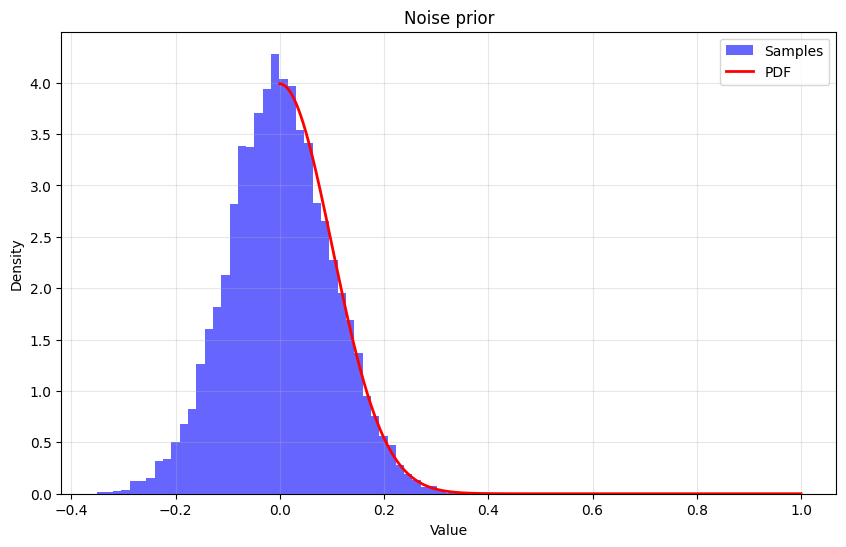

In [ ]:
# Generate samples
num_samples = 10000
samples = noise_prior.sample(torch.Size([num_samples]))

# Create the plot
plt.figure(figsize=(10, 6))

# Histogram of samples
plt.hist(samples.numpy(), bins=50, density=True, alpha=0.6, color='blue', label='Samples')

# Generate points for the PDF
x = np.linspace(0, 1, 1000)
pdf = noise_prior.log_prob(torch.tensor(x)).exp()
plt.plot(x, pdf, 'r-', lw=2, label='PDF')

plt.title('Noise prior')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 1g. Active-learning

In [ ]:
def plot_step(model, X, y, candidate, acq_func, discrete_points, step):
    # Create evaluation points (use discrete points for visualization)
    x_plot = discrete_points[:, 0]

    # Get posterior
    with torch.no_grad():
        posterior = model.posterior(discrete_points)
        mean = posterior.mean.squeeze()
        std = posterior.variance.sqrt().squeeze()


    # Get acquisition values
    with torch.no_grad():
        acq_values = acq_func(discrete_points.unsqueeze(1)).squeeze()

    # Ground truth
    y_true = func(x_plot.detach().numpy())

    plt.figure(figsize=(12, 6))

    # Plot posterior
    plt.subplot(1, 2, 1)
    plt.plot(x_plot.detach().numpy(), y_true, 'k--', label='True function')
    plt.plot(x_plot.detach().numpy(), mean.detach().numpy(), 'b-', label='Posterior mean')
    plt.fill_between(x_plot.detach().numpy(),
                    (mean - 2*std).detach().numpy(),
                    (mean + 2*std).detach().numpy(),
                    alpha=0.3, color='b')
    plt.plot(X.detach().numpy().squeeze(), y.detach().numpy(), 'r.', markersize=10, label='Observations')
    plt.plot(candidate.detach().numpy().squeeze(), func(candidate.detach().numpy().squeeze()), 'g*', markersize=15, label='Next point')
    plt.legend()
    plt.title(f'Step {step}: Posterior and Observations')

    # Plot acquisition function
    plt.subplot(1, 2, 2)
    plt.plot(x_plot.detach().numpy(), acq_values.detach().numpy(), 'r-', label='Acquisition function')
    plt.plot(candidate.detach().numpy().squeeze(),
            acq_func(candidate.unsqueeze(1)).detach().numpy(),
            'g*', markersize=15, label='Next point')
    plt.legend()
    plt.title('Acquisition Function')

    plt.tight_layout()
    # plt.savefig(f"{out_dir}/{step}.png")
    plt.show()


In [ ]:
def print_detailed_model_parameters(model):
    """
    Print detailed statistics about the GP model parameters
    """
    # Lengthscale
    lengthscale = model.covar_module.base_kernel.lengthscale
    print("\nLengthscale:")
    print(f"  Value: {lengthscale.item():.3f}")
    if hasattr(model.covar_module.base_kernel, 'lengthscale_prior'):
        prior = model.covar_module.base_kernel.lengthscale_prior
        print(f"  Prior mean: {prior.mean.item():.3f}")
        print(f"  Prior std: {prior.stddev.item():.3f}")

    # Outputscale
    outputscale = model.covar_module.outputscale
    print("\nOutputscale:")
    print(f"  Value: {outputscale.item():.3f}")
    if hasattr(model.covar_module, 'outputscale_prior'):
        prior = model.covar_module.outputscale_prior
        print(f"  Prior mean: {prior.mean.item():.3f}")
        print(f"  Prior std: {prior.stddev.item():.3f}")

    # Noise
    noise = model.likelihood.noise
    print("\nNoise:")
    print(f"  Value: {noise.item():.3f}")
    if hasattr(model.likelihood, 'noise_prior'):
        prior = model.likelihood.noise_prior
        print(f"  Prior mean: {prior.mean.item():.3f}")
        print(f"  Prior std: {prior.stddev.item():.3f}")


/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))
/tmp/ipython-input-14-1492585536.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(measure(X, noise=0), dtype=torch.double)



Lengthscale:
  Value: 0.109
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


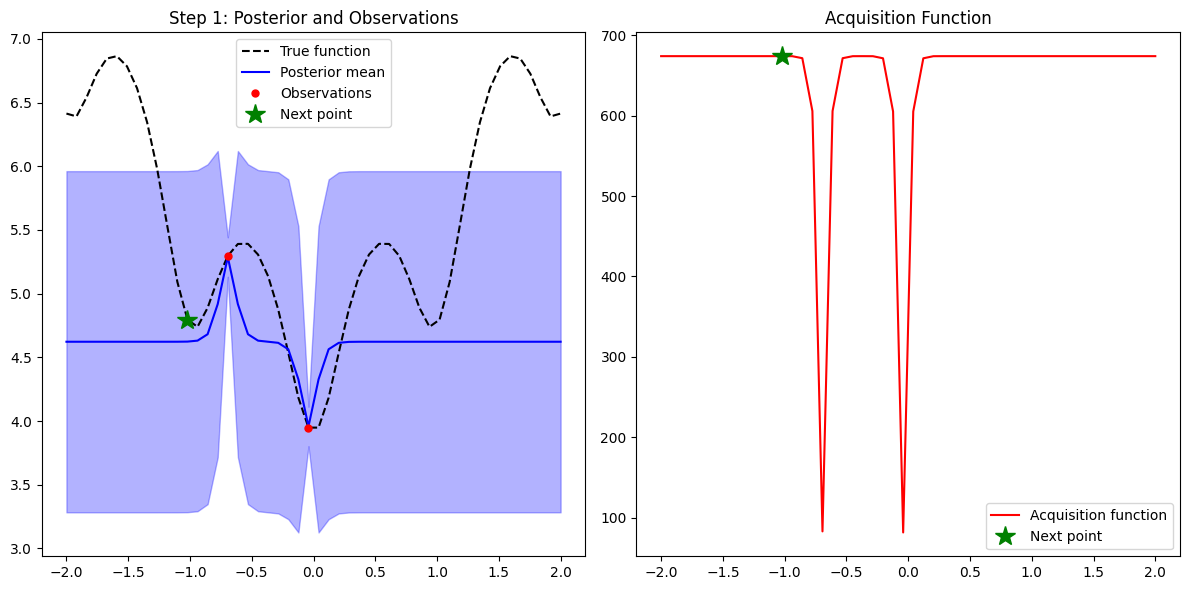

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.186
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


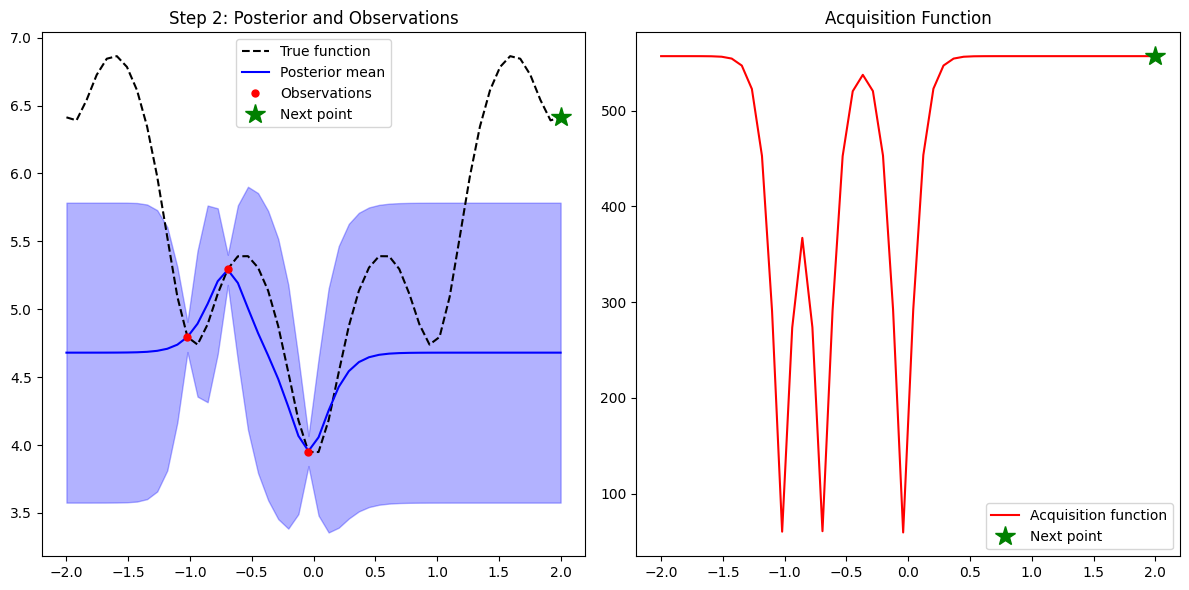

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.100
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


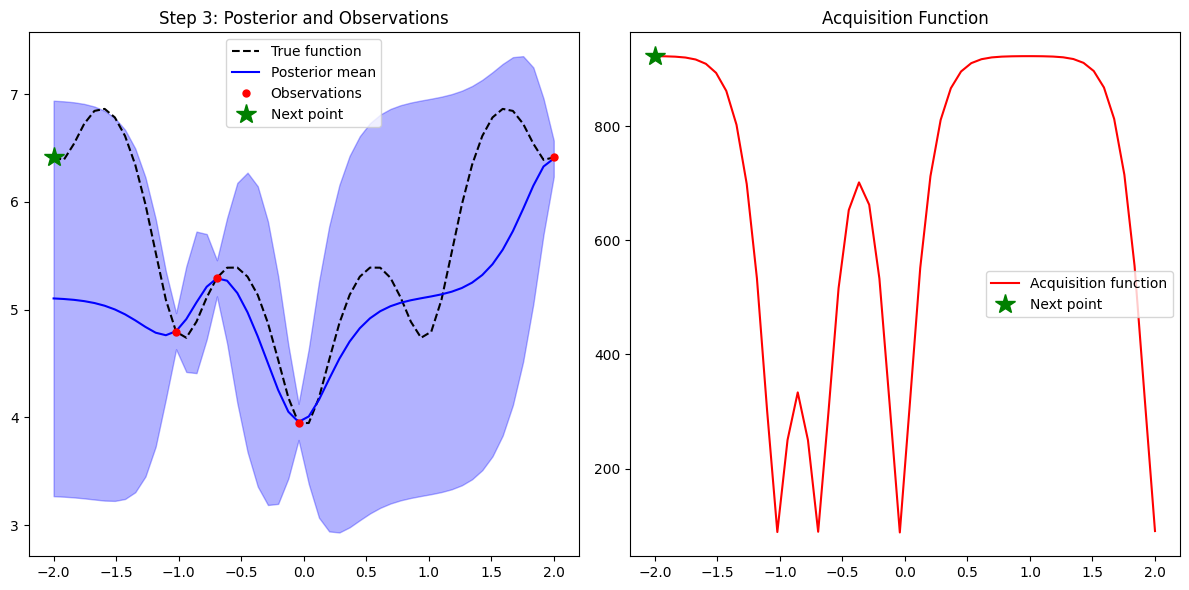

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.100
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


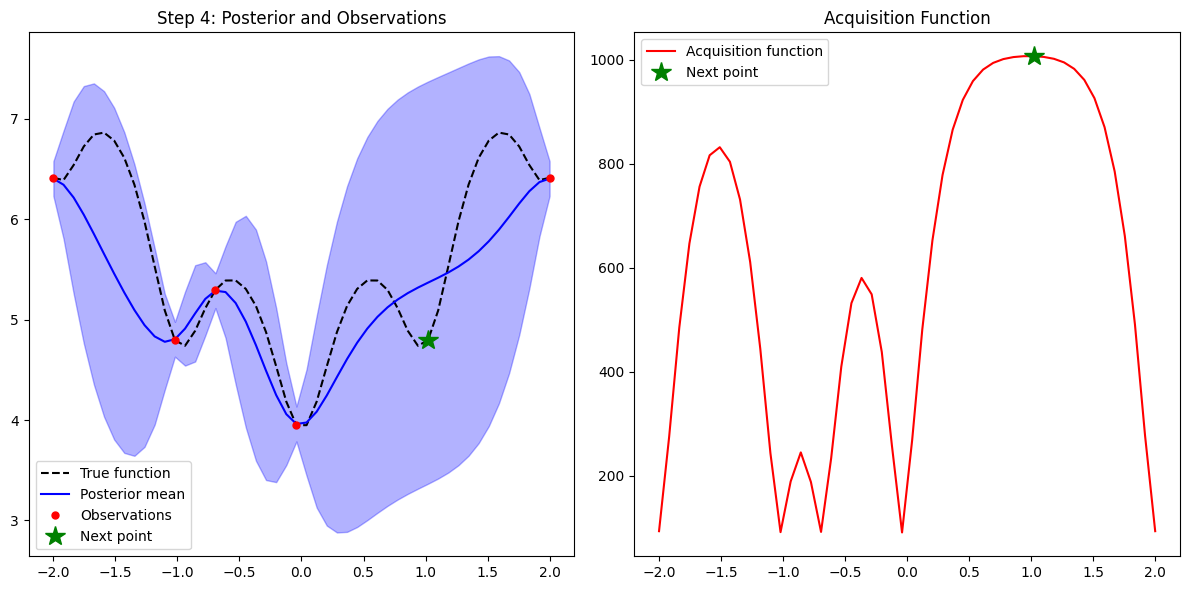

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.100
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


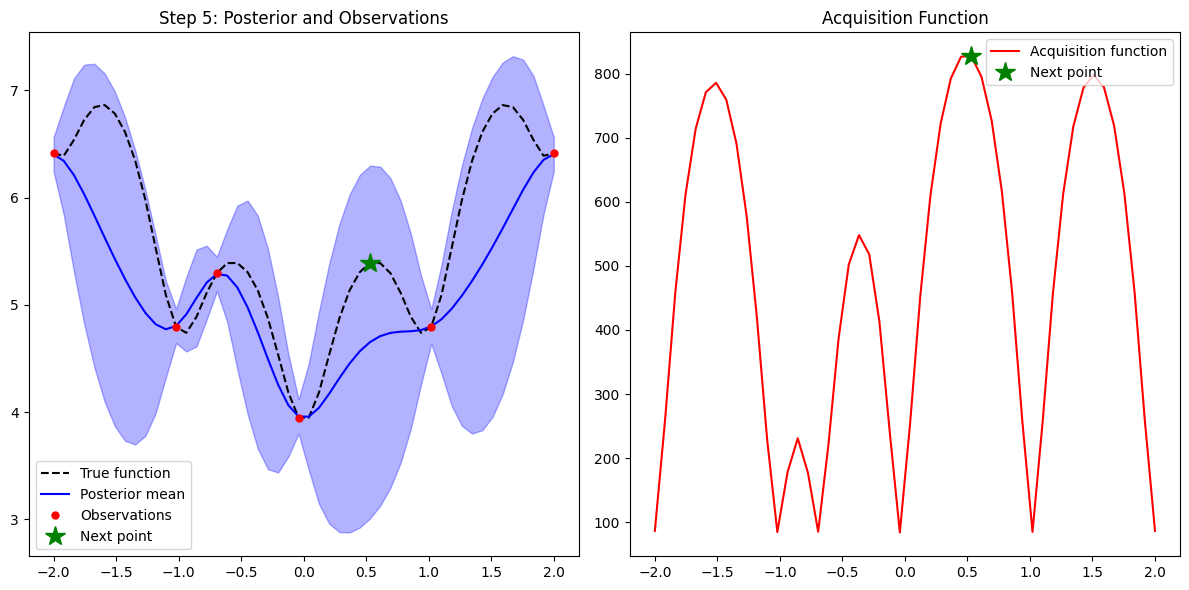

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.100
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


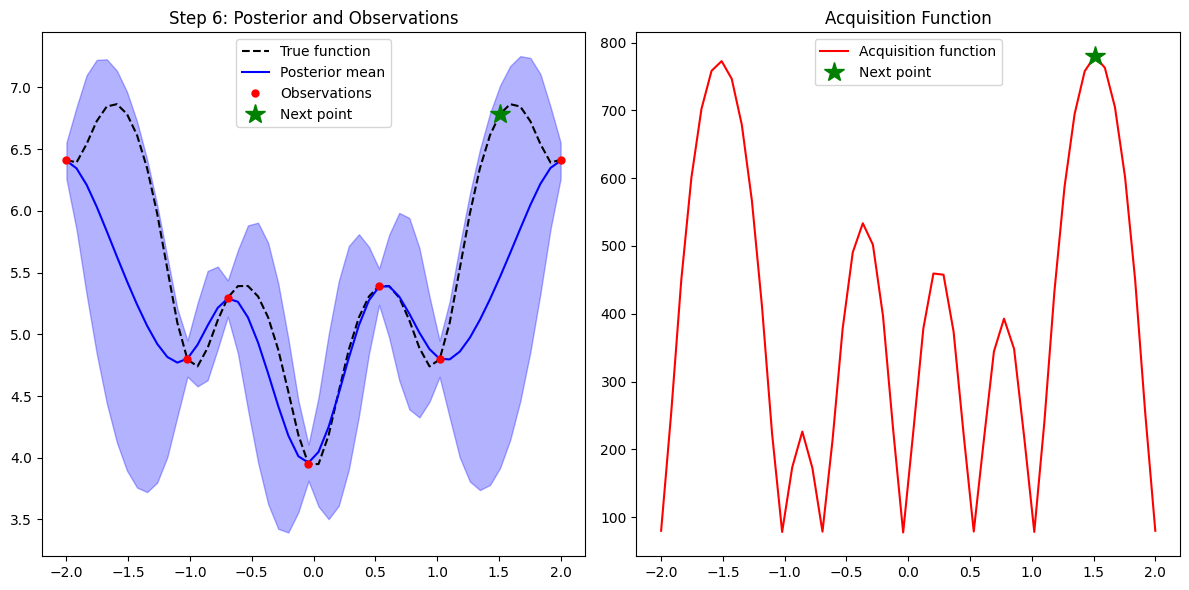

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.100
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


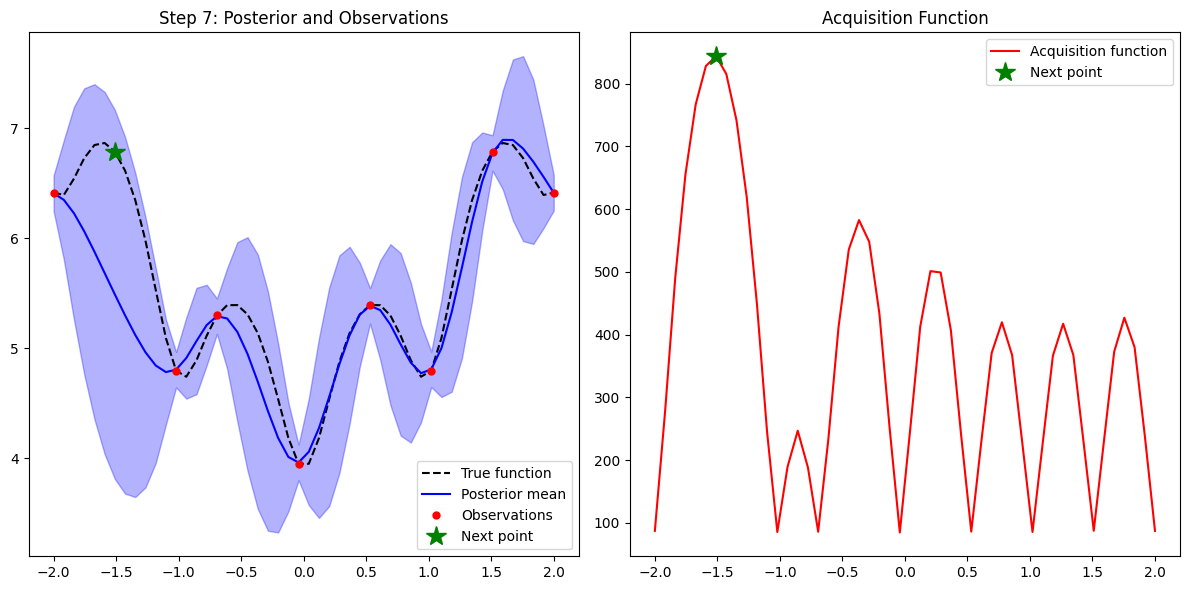

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.100
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


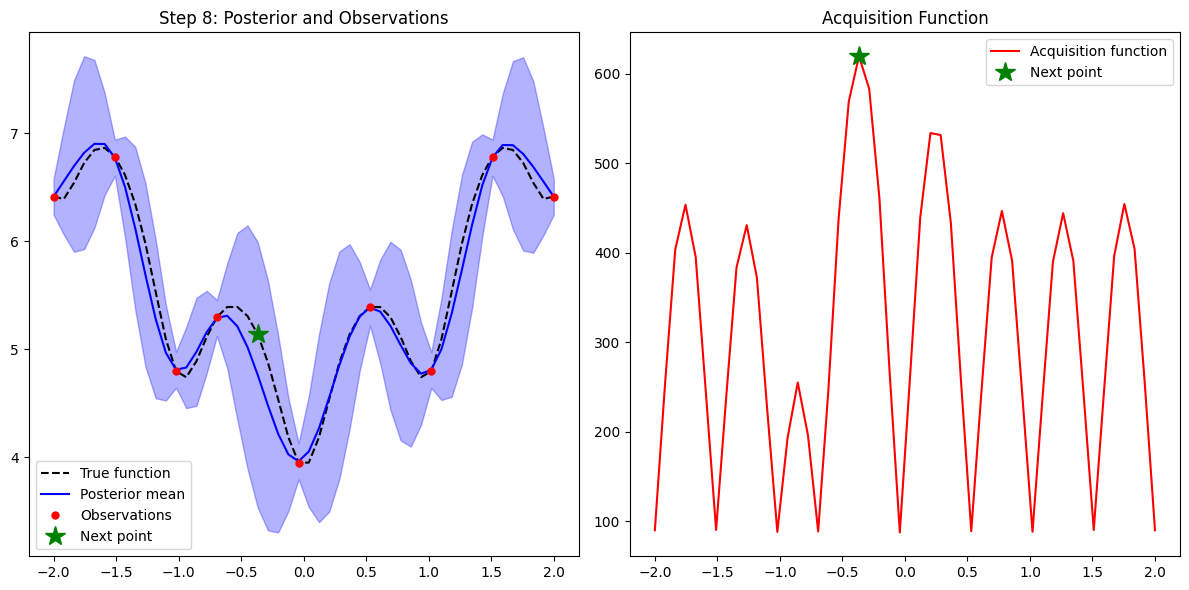

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.100
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


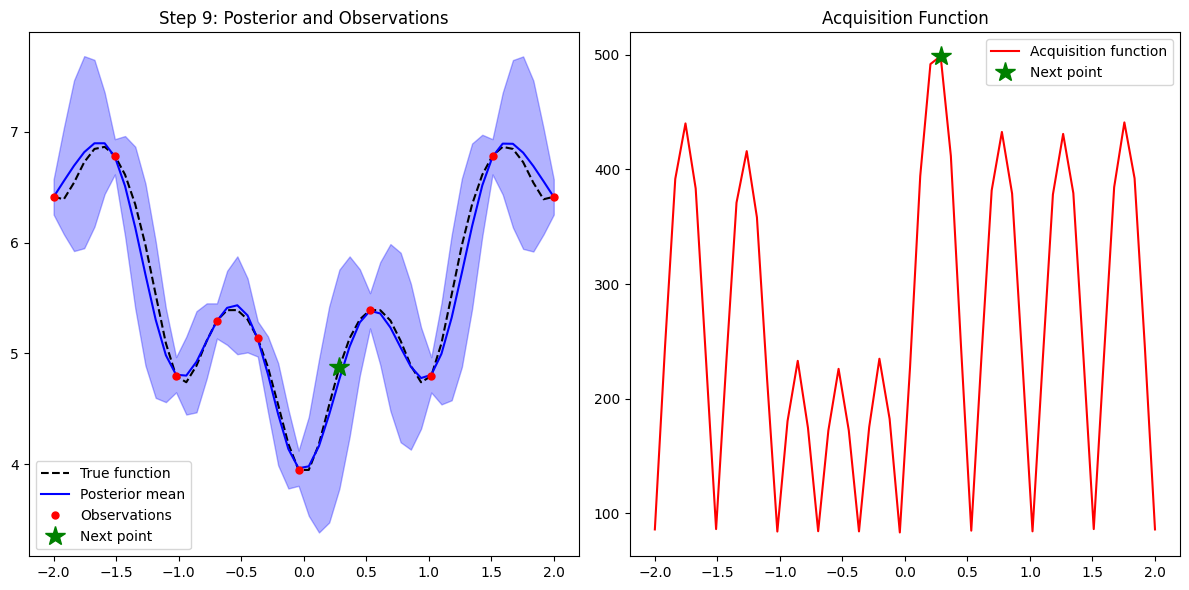

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.100
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


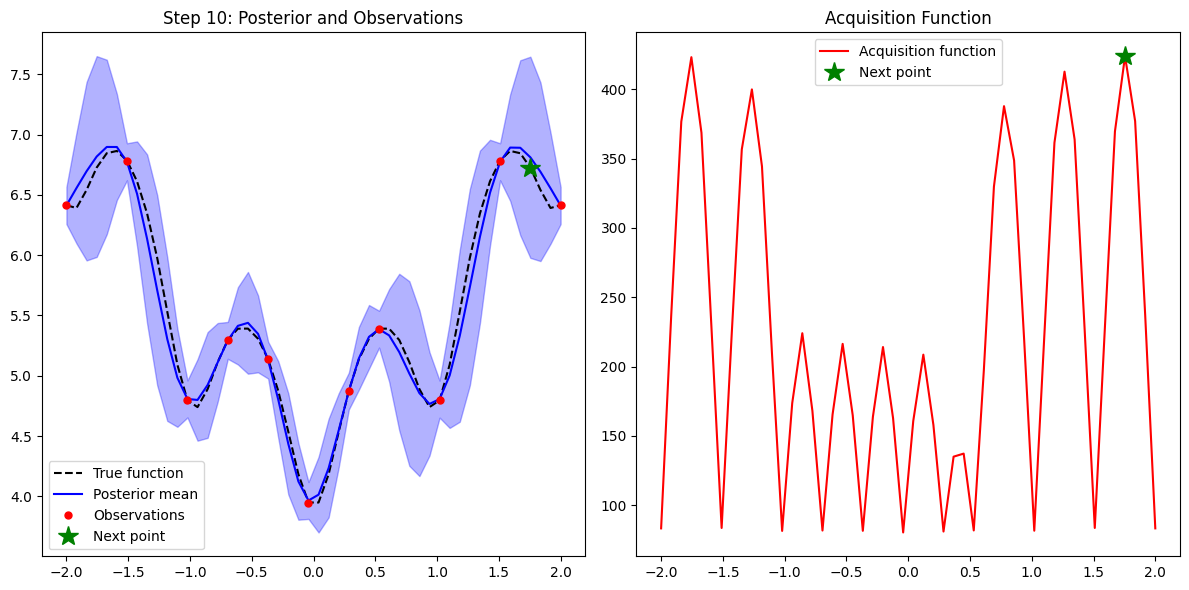


Optimization completed!
Best observed value: 3.949
At location: -0.041


/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))


In [ ]:
# Create discrete grid
x_points = torch.linspace(-2, 2, 50, dtype=torch.double)
discrete_points = x_points.unsqueeze(-1)

# Initial training data
n_train = 2
train_indices = torch.randperm(len(discrete_points))[:n_train]
X = discrete_points[train_indices]
# y = torch.tensor(measure(X), dtype=torch.double)
y = torch.tensor(measure(X, noise=0), dtype=torch.double)


n_iterations = 10
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf_discrete
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import UpperConfidenceBound
from torch.optim import Adam


for step in range(n_iterations):
    # Fit GP
    model = CustomGP(X, y, kernel, lengthscale_prior, outputscale_prior, noise_prior)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    print_detailed_model_parameters(model)


    # Define acquisition function
    # EI = ExpectedImprovement(model=model, best_f=y.min())
    # UCB = UpperConfidenceBound(model=model, beta=0)  # beta controls exploration vs exploitation
    # Define acquisition function
    acq_func = UpperConfidenceBound(model=model, beta = 1e6 ) #--> higher beta maximum uncertanity
    # Get remaining points (exclude training points)
    mask = torch.ones(len(discrete_points), dtype=torch.bool)
    mask[train_indices] = False
    available_points = discrete_points[mask]

    # Optimize acquisition function discretely
    candidate, acq_value = optimize_acqf_discrete(
        acq_function=acq_func,
        q=1,
        choices=available_points,
        unique=True,
    )

    # Plot
    plot_step(model, X, y, candidate, acq_func, discrete_points, step + 1)

    # Update data
    X = torch.cat([X, candidate])
    y_new = torch.tensor([[measure(candidate.item(), noise=0)]], dtype=torch.double)

    y = torch.cat([y, y_new])

    # Update training indices
    new_idx = torch.where((discrete_points == candidate).all(dim=1))[0]
    train_indices = torch.cat([train_indices, new_idx])

print("\nOptimization completed!")
print(f"Best observed value: {y.min().detach().item():.3f}")
print(f"At location: {X[y.argmin()].detach().item():.3f}")


# 2.Mean Functions - Structured GP
- Rewritten in Gpytorch and Botorch by [Utkarsh Pratiush](https://github.com/utkarshp1161). [Originally in Gpax](https://github.com/SergeiVKalinin/ACerS_AE_2024/blob/main/10_GPax_sGP_AE.ipynb) by [Maxim Ziatdinov](https://github.com/ziatdinovmax) and [SVK](https://github.com/SergeiVKalinin).

## 2a. Mean function - 1

### 2a(i).Define mean function

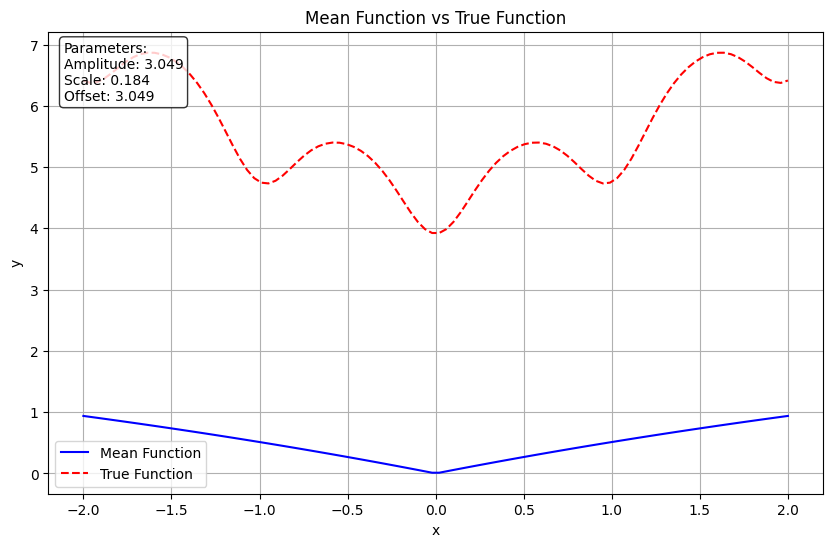

In [ ]:
class CustomMean(gpytorch.means.Mean):
    def __init__(self, batch_shape=torch.Size()):
        super().__init__()

        # Register raw parameters (will be transformed to ensure positivity)
        self.register_parameter(
            name="raw_amplitude",
            parameter=torch.nn.Parameter(torch.tensor(3.0))  # log(20) ≈ 3
        )
        self.register_parameter(
            name="raw_scale",
            parameter=torch.nn.Parameter(torch.tensor(-1.6))  # log(0.2) ≈ -1.6
        )
        self.register_parameter(
            name="raw_offset",
            parameter=torch.nn.Parameter(torch.tensor(3.0))  # log(20) ≈ 3
        )

        # Register constraints
        self.register_constraint("raw_amplitude", Positive())
        self.register_constraint("raw_scale", Positive())
        self.register_constraint("raw_offset", Positive())

        # Register priors
        self.register_prior(
            "amplitude_prior",
            LogNormalPrior(3.0, 0.5),  # mean=log(20), std=0.5
            lambda module: module.amplitude,
            lambda module, value: module._set_amplitude(value)
        )
        self.register_prior(
            "scale_prior",
            LogNormalPrior(-1.6, 0.5),  # mean=log(0.2), std=0.5
            lambda module: module.scale,
            lambda module, value: module._set_scale(value)
        )
        self.register_prior(
            "offset_prior",
            LogNormalPrior(3.0, 0.5),  # mean=log(20), std=0.5
            lambda module: module.offset,
            lambda module, value: module._set_offset(value)
        )

    # Properties to transform raw parameters
    @property
    def amplitude(self):
        return self.raw_amplitude_constraint.transform(self.raw_amplitude)

    @property
    def scale(self):
        return self.raw_scale_constraint.transform(self.raw_scale)

    @property
    def offset(self):
        return self.raw_offset_constraint.transform(self.raw_offset)

    # Setters for parameters
    def _set_amplitude(self, value):
        if not torch.is_tensor(value):
            value = torch.tensor(value)
        self.initialize(raw_amplitude=self.raw_amplitude_constraint.inverse_transform(value))

    def _set_scale(self, value):
        if not torch.is_tensor(value):
            value = torch.tensor(value)
        self.initialize(raw_scale=self.raw_scale_constraint.inverse_transform(value))

    def _set_offset(self, value):
        if not torch.is_tensor(value):
            value = torch.tensor(value)
        self.initialize(raw_offset=self.raw_offset_constraint.inverse_transform(value))

    def forward(self, x):
        if x.ndimension() == 1:
            x = x.unsqueeze(-1)

        # Use transformed parameters in the computation
        term1 = -self.amplitude * torch.exp(-self.scale * torch.sqrt(torch.sum(x**2, dim=-1)))
        return term1 + self.offset


def plot_mean_function(mean_module, x_range=(-2, 2), n_points=100):
    """
    Plot the mean function over a specified range.

    Args:
        mean_module: The CustomMean instance
        x_range: Tuple of (min_x, max_x)
        n_points: Number of points to evaluate
    """
    # Create evaluation points
    x = np.linspace(x_range[0], x_range[1], n_points)
    x_tensor = torch.tensor(x, dtype=torch.float64).reshape(-1, 1)

    # Evaluate mean function
    with torch.no_grad():
        mean_values = mean_module(x_tensor).numpy()

    # Create figure
    plt.figure(figsize=(10, 6))

    # Plot mean function
    plt.plot(x, mean_values, 'b-', label='Mean Function')

    # Plot true function for comparison
    true_y = np.array([func(xi) for xi in x])
    plt.plot(x, true_y, 'r--', label='True Function')

    # Add labels and title
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Mean Function vs True Function')
    plt.legend()
    plt.grid(True)

    # Show parameter values
    param_text = f'Parameters:\nAmplitude: {mean_module.amplitude.item():.3f}\n'
    param_text += f'Scale: {mean_module.scale.item():.3f}\n'
    param_text += f'Offset: {mean_module.offset.item():.3f}'

    plt.text(0.02, 0.98, param_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.show()

# Create and plot mean function
mean_module = CustomMean()
plot_mean_function(mean_module)

### 2b(ii). Define model

In [ ]:
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize, Normalize
# from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.kernels import  ScaleKernel

from gpytorch.constraints import GreaterThan

class CustomGP(SingleTaskGP):
    def __init__(self, train_X, train_Y, kernel, lengthscale_prior, outputscale_prior, noise_prior):
        super().__init__(
            train_X,
            train_Y,
            input_transform=Normalize(d=1),
            outcome_transform=Standardize(m=1)
        )

        # Replace default mean module with custom mean
        self.mean_module = CustomMean()
        # self.mean_module = AckleyMean()

        # Replace default kernel with custom kernel
        self.covar_module = ScaleKernel(kernel)

        # Register priors
        self.covar_module.base_kernel.register_prior(
            "lengthscale_prior",
            lengthscale_prior,
            lambda module: module.lengthscale,
            lambda module, value: module._set_lengthscale(value)
        )

        self.covar_module.register_prior(
            "outputscale_prior",
            outputscale_prior,
            lambda module: module.outputscale
        )

        self.likelihood.register_prior(
            "noise_prior",
            noise_prior,
            lambda module: module.noise
        )

        self.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))

### 2c(iii). Register kerne-priors

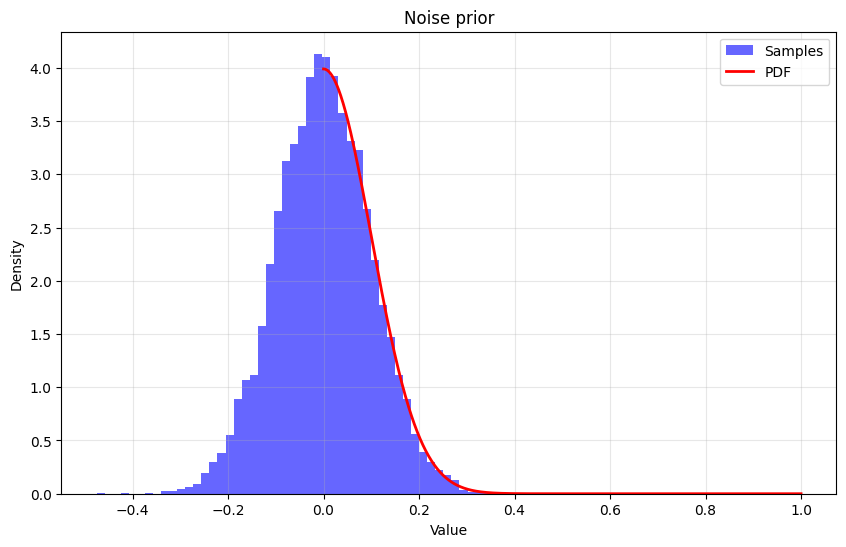

In [ ]:
### more kernel's to try
class RBFKernel(gpytorch.kernels.Kernel):
    is_stationary = True

    def __init__(self, variance_prior=None, length_prior=None,
                 variance_constraint=None, length_constraint=None, **kwargs):
        super().__init__(**kwargs)

        # Register raw parameters
        self.register_parameter(
            name='raw_lengthscale',  # Changed from raw_length to raw_lengthscale
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )
        self.register_parameter(
            name='raw_variance',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )

        # Set constraints
        if length_constraint is None:
            length_constraint = Positive()
        if variance_constraint is None:
            variance_constraint = Positive()

        self.register_constraint("raw_lengthscale", length_constraint)
        self.register_constraint("raw_variance", variance_constraint)

        # Set priors if any
        if length_prior is not None:
            self.register_prior(
                "lengthscale_prior",  # Changed from length_prior to lengthscale_prior
                length_prior,
                lambda m: m.lengthscale,  # Changed from length to lengthscale
                lambda m, v: m._set_lengthscale(v),  # Changed from _set_length
            )
        if variance_prior is not None:
            self.register_prior(
                "variance_prior",
                variance_prior,
                lambda m: m.variance,
                lambda m, v: m._set_variance(v),
            )

    # Lengthscale property
    @property
    def lengthscale(self):  # Changed from length to lengthscale
        return self.raw_lengthscale_constraint.transform(self.raw_lengthscale)

    @lengthscale.setter
    def lengthscale(self, value):
        return self._set_lengthscale(value)

    def _set_lengthscale(self, value):  # Changed from _set_length
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_lengthscale)
        self.initialize(raw_lengthscale=self.raw_lengthscale_constraint.inverse_transform(value))

    # Variance property
    @property
    def variance(self):
        return self.raw_variance_constraint.transform(self.raw_variance)

    @variance.setter
    def variance(self, value):
        return self._set_variance(value)

    def _set_variance(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_variance)
        self.initialize(raw_variance=self.raw_variance_constraint.inverse_transform(value))

    def forward(self, x1, x2, **params):
        dist = self.covar_dist(x1, x2, **params)
        scaled_dist = dist.div(self.lengthscale)
        return self.variance * torch.exp(-0.5 * scaled_dist.pow(2))

class Matern52Kernel(gpytorch.kernels.Kernel):
    is_stationary = True

    def __init__(self, variance_prior=None, length_prior=None,
                 variance_constraint=None, length_constraint=None, **kwargs):
        super().__init__(**kwargs)

        # Register raw parameters
        self.register_parameter(
            name='raw_lengthscale',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )
        self.register_parameter(
            name='raw_variance',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )

        # Set constraints
        if length_constraint is None:
            length_constraint = Positive()
        if variance_constraint is None:
            variance_constraint = Positive()

        self.register_constraint("raw_lengthscale", length_constraint)
        self.register_constraint("raw_variance", variance_constraint)

        # Set priors if any
        if length_prior is not None:
            self.register_prior(
                "lengthscale_prior",
                length_prior,
                lambda m: m.lengthscale,
                lambda m, v: m._set_lengthscale(v),
            )
        if variance_prior is not None:
            self.register_prior(
                "variance_prior",
                variance_prior,
                lambda m: m.variance,
                lambda m, v: m._set_variance(v),
            )

    # Lengthscale property
    @property
    def lengthscale(self):
        return self.raw_lengthscale_constraint.transform(self.raw_lengthscale)

    @lengthscale.setter
    def lengthscale(self, value):
        return self._set_lengthscale(value)

    def _set_lengthscale(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_lengthscale)
        self.initialize(raw_lengthscale=self.raw_lengthscale_constraint.inverse_transform(value))

    # Variance property
    @property
    def variance(self):
        return self.raw_variance_constraint.transform(self.raw_variance)

    @variance.setter
    def variance(self, value):
        return self._set_variance(value)

    def _set_variance(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_variance)
        self.initialize(raw_variance=self.raw_variance_constraint.inverse_transform(value))

    def forward(self, x1, x2, **params):
        dist = self.covar_dist(x1, x2, **params)
        scaled_dist = dist.div(self.lengthscale)

        # Matern 5/2 formula
        sqrt_5 = math.sqrt(5.0)
        scaled_dist_5_3 = scaled_dist * sqrt_5

        return self.variance * (1.0 + scaled_dist_5_3 + (5.0/3.0) * scaled_dist.pow(2)) * \
               torch.exp(-scaled_dist_5_3)

class PeriodicKernel(gpytorch.kernels.Kernel):
    is_stationary = True

    def __init__(self, period_prior=None, length_prior=None, variance_prior=None,
                 period_constraint=None, length_constraint=None, variance_constraint=None, **kwargs):
        super().__init__(**kwargs)

        # Register raw parameters
        self.register_parameter(
            name='raw_period',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )
        self.register_parameter(
            name='raw_lengthscale',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )
        self.register_parameter(
            name='raw_variance',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )

        # Set constraints
        if period_constraint is None:
            period_constraint = Positive()
        if length_constraint is None:
            length_constraint = Positive()
        if variance_constraint is None:
            variance_constraint = Positive()

        self.register_constraint("raw_period", period_constraint)
        self.register_constraint("raw_lengthscale", length_constraint)
        self.register_constraint("raw_variance", variance_constraint)

        # Set priors if any
        if period_prior is not None:
            self.register_prior(
                "period_prior",
                period_prior,
                lambda m: m.period,
                lambda m, v: m._set_period(v),
            )
        if length_prior is not None:
            self.register_prior(
                "lengthscale_prior",
                length_prior,
                lambda m: m.lengthscale,
                lambda m, v: m._set_lengthscale(v),
            )
        if variance_prior is not None:
            self.register_prior(
                "variance_prior",
                variance_prior,
                lambda m: m.variance,
                lambda m, v: m._set_variance(v),
            )

    # Period property
    @property
    def period(self):
        return self.raw_period_constraint.transform(self.raw_period)

    @period.setter
    def period(self, value):
        return self._set_period(value)

    def _set_period(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_period)
        self.initialize(raw_period=self.raw_period_constraint.inverse_transform(value))

    # Lengthscale property
    @property
    def lengthscale(self):
        return self.raw_lengthscale_constraint.transform(self.raw_lengthscale)

    @lengthscale.setter
    def lengthscale(self, value):
        return self._set_lengthscale(value)

    def _set_lengthscale(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_lengthscale)
        self.initialize(raw_lengthscale=self.raw_lengthscale_constraint.inverse_transform(value))

    # Variance property
    @property
    def variance(self):
        return self.raw_variance_constraint.transform(self.raw_variance)

    @variance.setter
    def variance(self, value):
        return self._set_variance(value)

    def _set_variance(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_variance)
        self.initialize(raw_variance=self.raw_variance_constraint.inverse_transform(value))

    def forward(self, x1, x2, **params):
        dist = self.covar_dist(x1, x2, **params)
        # Periodic kernel formula: k(x,x') = σ² * exp(-2 * sin²(π|x-x'|/p) / ℓ²)
        scaled_sin = torch.sin(math.pi * dist / self.period)
        exp_term = -2 * (scaled_sin ** 2) / (self.lengthscale ** 2)
        return self.variance * torch.exp(exp_term)



## define priors
from gpytorch.priors import GammaPrior, NormalPrior
from gpytorch.priors import UniformPrior, LogNormalPrior, HalfNormalPrior, NormalPrior
from gpytorch.constraints import Interval

lengthscale_prior = UniformPrior(0.10, 0.5)# length scale in RBF kernel
outputscale_prior = LogNormalPrior(0, 1)# Variance in RBF kernel
# noise_prior = HalfNormalPrior(0.01, 1)
noise_prior = NormalPrior(0, 0.1)
length_constraint = Interval(0.10, 0.5)  # Matching constraint to lengthscale_prior distribution support , kernel length often need constraints (e.g., positive values) -

# kernel = RBFKernel(length_prior=lengthscale_prior,
#                    length_constraint=length_constraint
#                    )
kernel = Matern52Kernel(length_prior=lengthscale_prior,
                   length_constraint=length_constraint
                   )
# kernel = PeriodicKernel(length_prior=lengthscale_prior,
#                    length_constraint=length_constraint
#                    )

## more priors: GammaPrior, HalfCauchyPrior, LKJCovariancePrior, MultivariateNormalPrior, NormalPrior, SmoothedBoxPrior, UniformPrior, LogNormalPrior

# Generate samples
num_samples = 10000
samples = noise_prior.sample(torch.Size([num_samples]))

# Create the plot
plt.figure(figsize=(10, 6))

# Histogram of samples
plt.hist(samples.numpy(), bins=50, density=True, alpha=0.6, color='blue', label='Samples')

# Generate points for the PDF
x = np.linspace(0, 1, 1000)
pdf = noise_prior.log_prob(torch.tensor(x)).exp()
plt.plot(x, pdf, 'r-', lw=2, label='PDF')

plt.title('Noise prior')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 2d(iv). Active learning

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))
/tmp/ipython-input-18-1492585536.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(measure(X, noise=0), dtype=torch.double)
/usr/local/lib/python3.11/dist-packages/botorch/models/utils/assorted.py:268: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], dtype=torch.float64), mean = tensor([0.], dtype=torch.float64)).Please con


Lengthscale:
  Value: 0.109
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


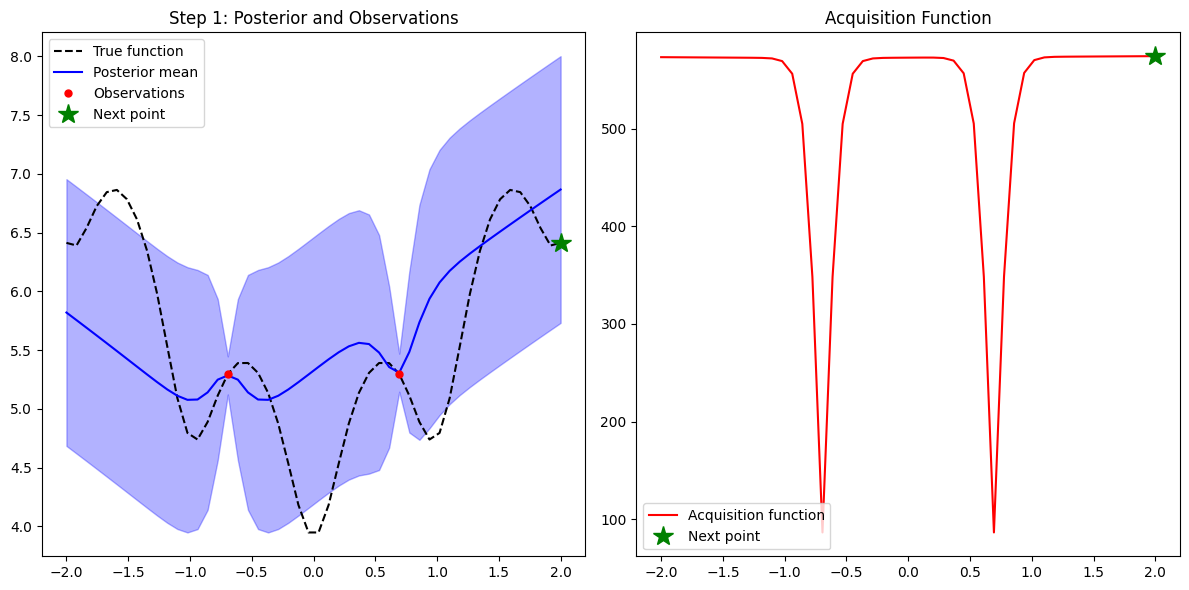

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.100
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


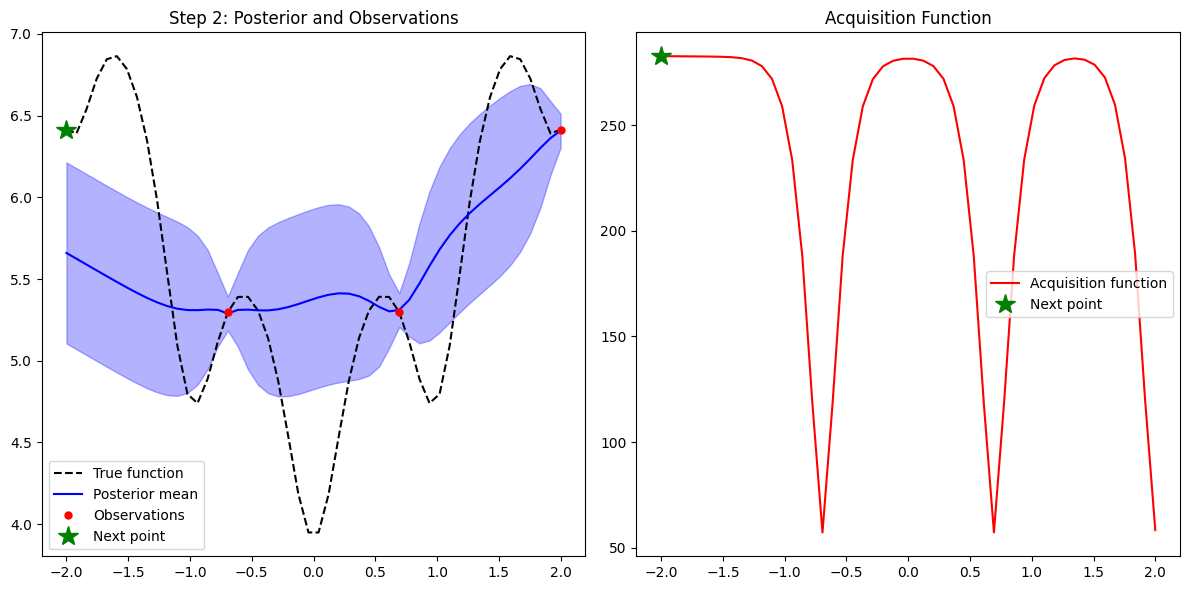

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.100
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


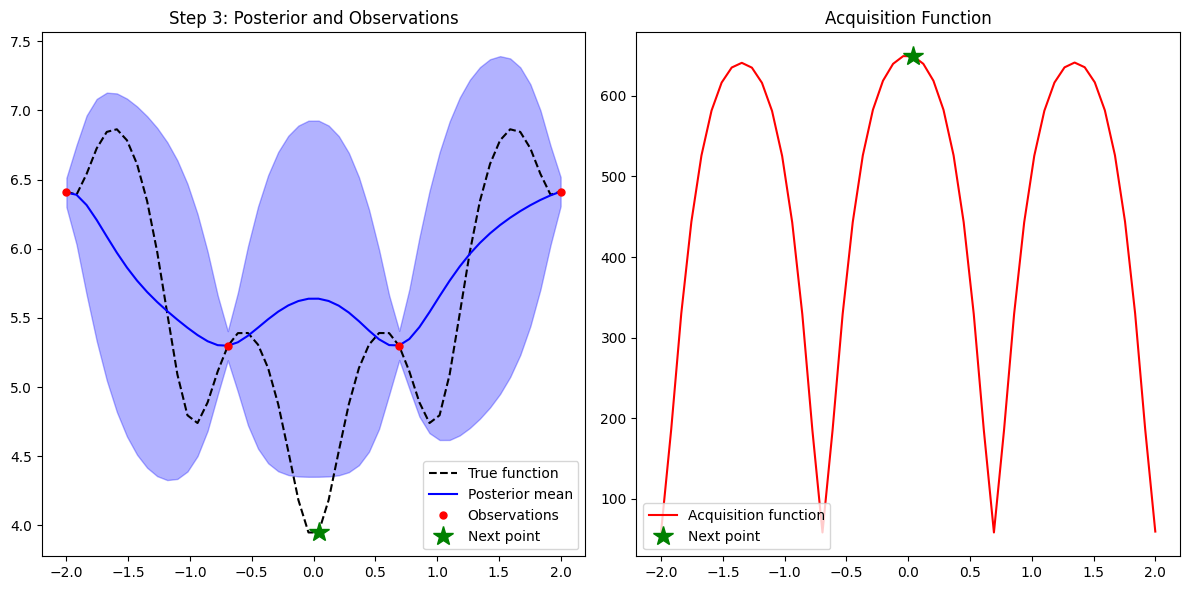

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.100
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


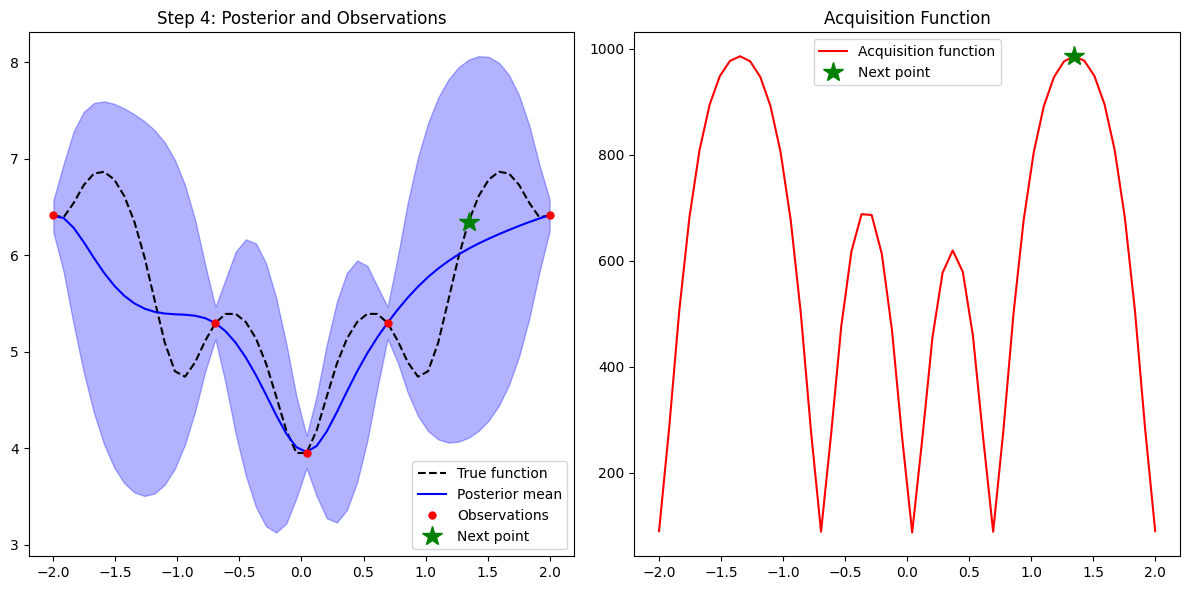

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.100
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


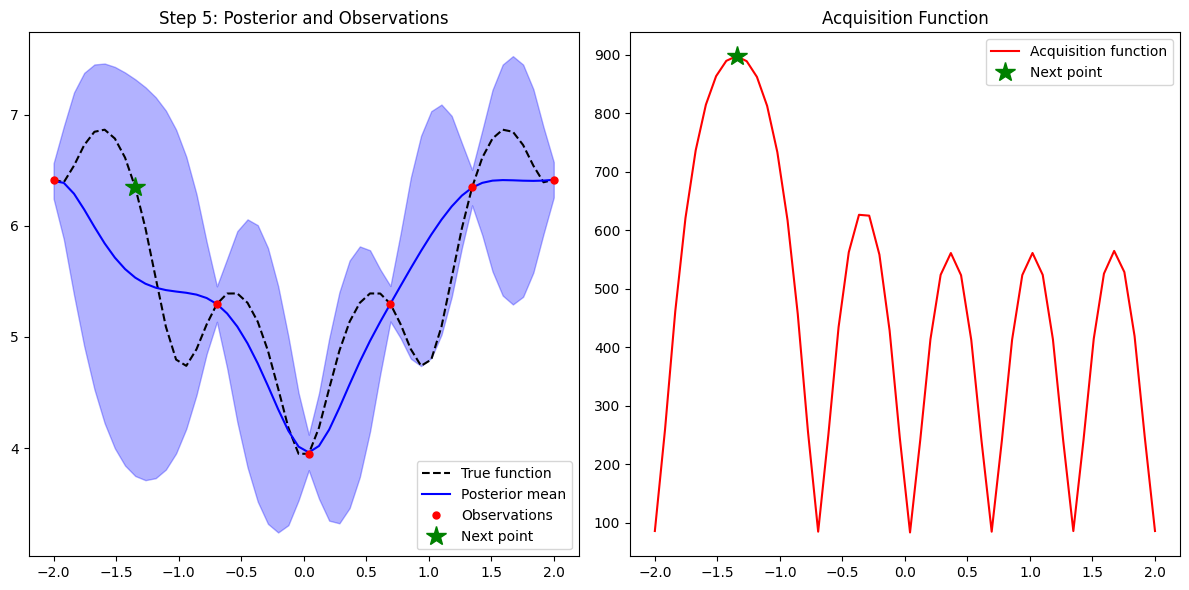

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.100
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


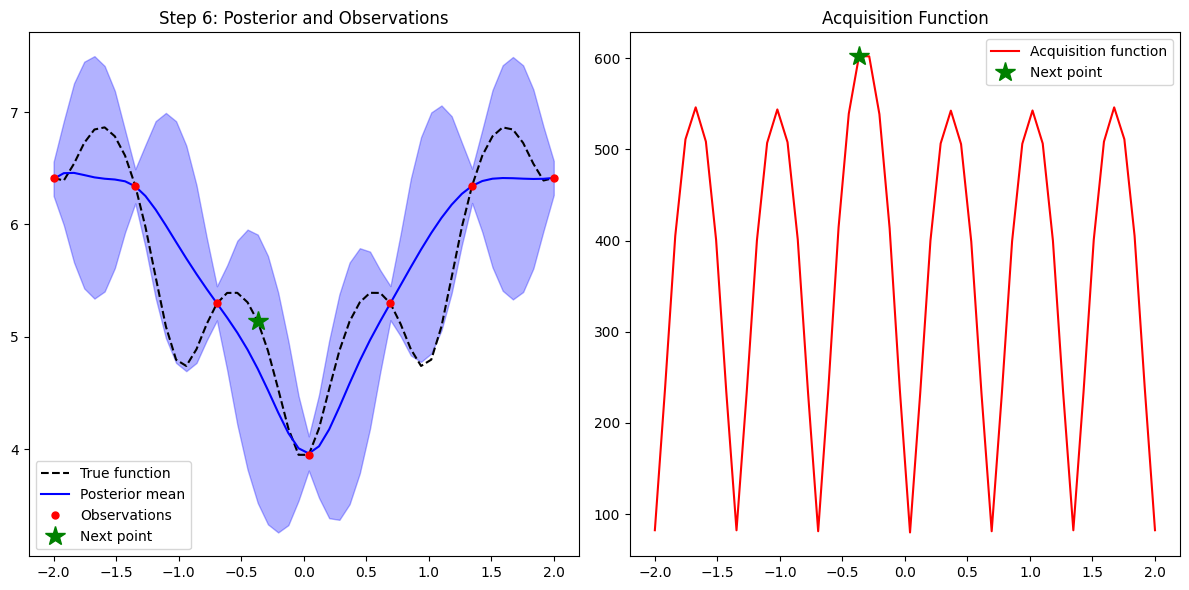

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.100
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


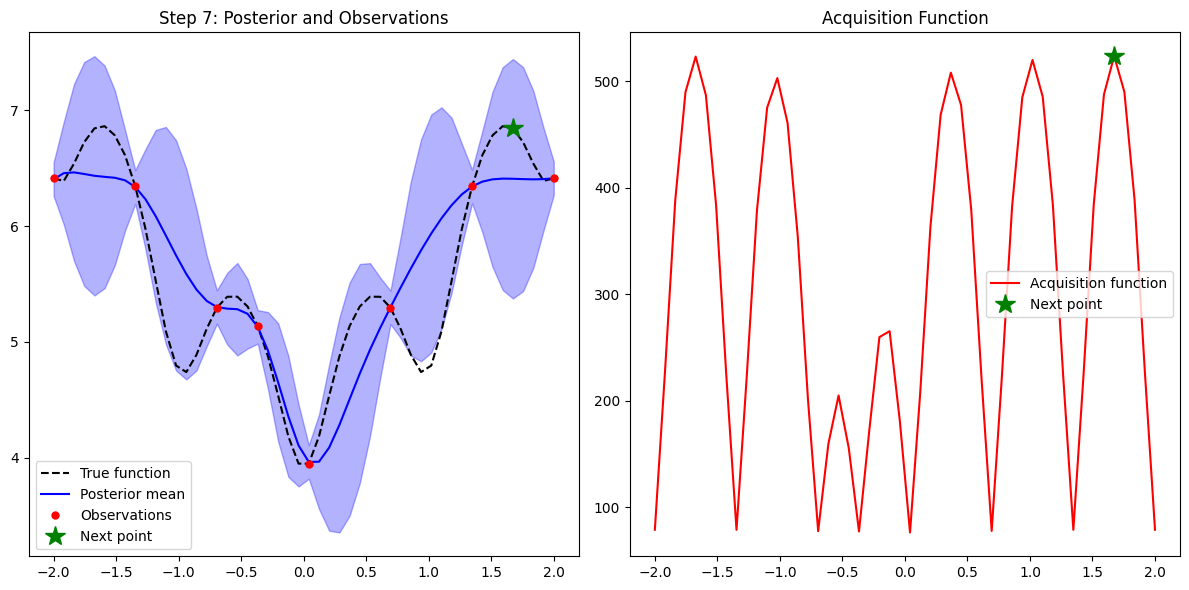

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.100
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


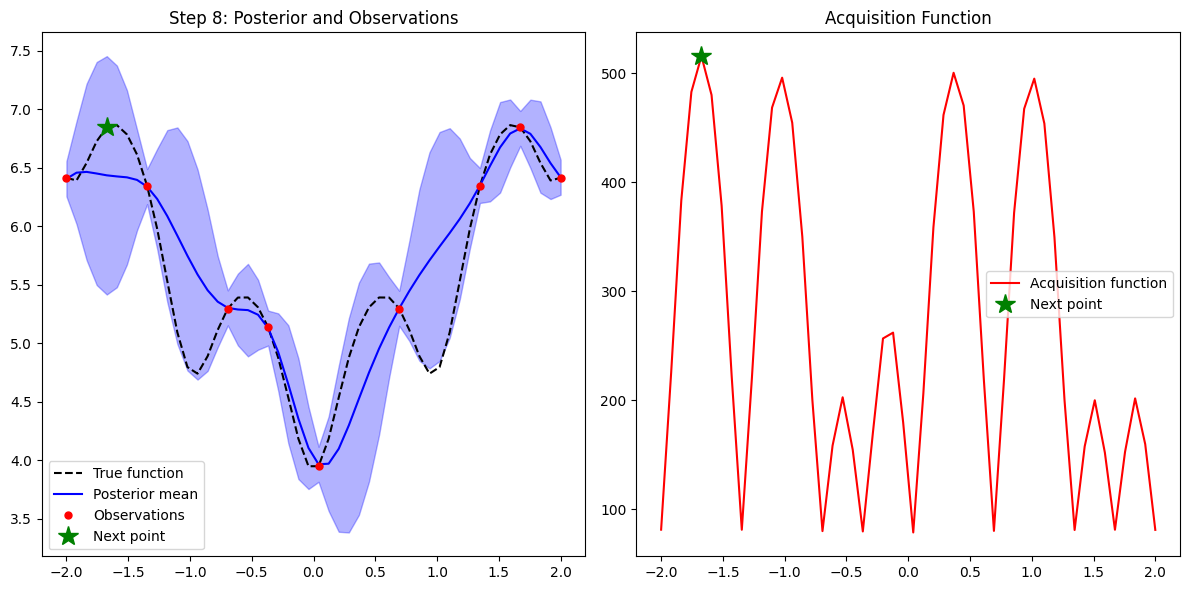

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.100
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


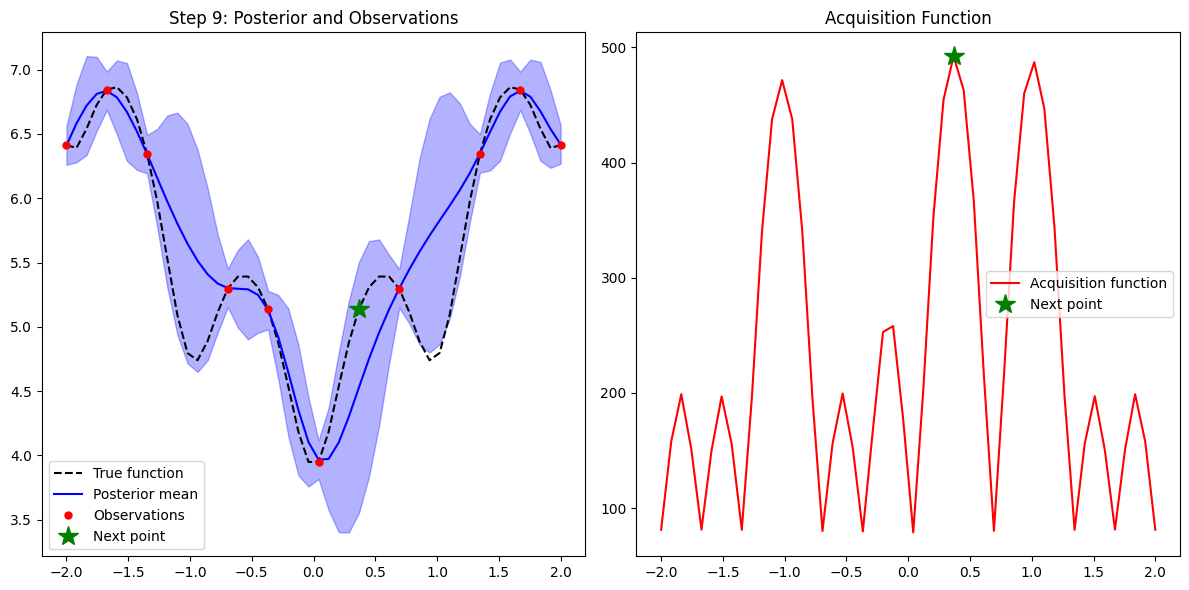

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.100
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


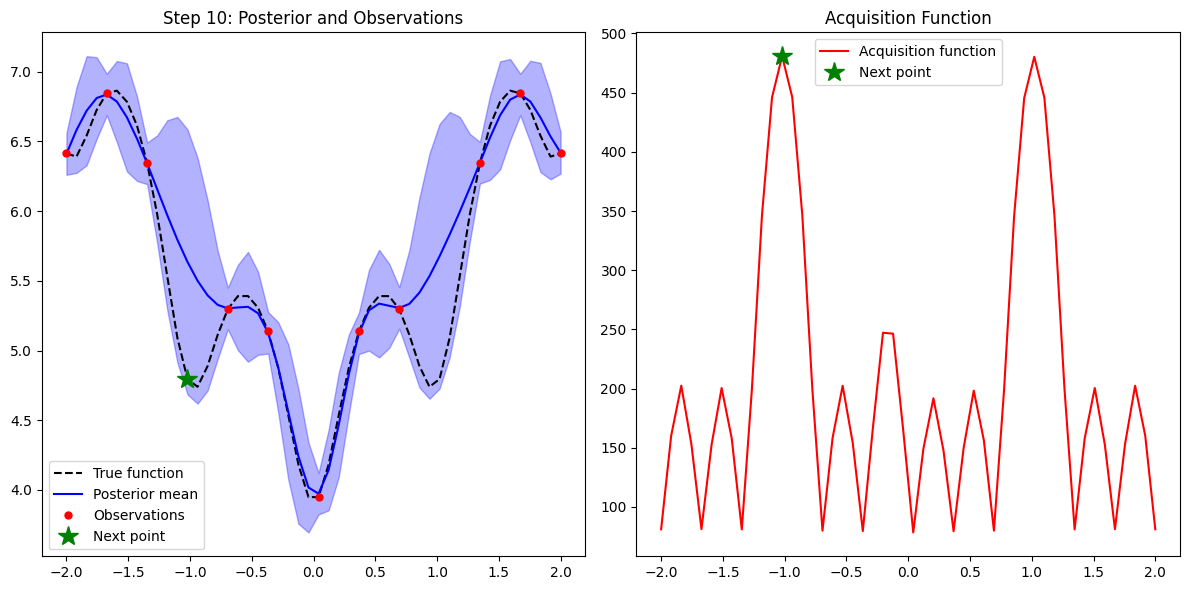


Optimization completed!
Best observed value: 3.949
At location: 0.041


/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))


In [ ]:
# Create discrete grid
x_points = torch.linspace(-2, 2, 50, dtype=torch.double)
discrete_points = x_points.unsqueeze(-1)

# Initial training data
n_train = 2
train_indices = torch.randperm(len(discrete_points))[:n_train]
X = discrete_points[train_indices]
# y = torch.tensor(measure(X), dtype=torch.double)
y = torch.tensor(measure(X, noise=0), dtype=torch.double)


n_iterations = 10
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf_discrete
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import UpperConfidenceBound
from torch.optim import Adam


for step in range(n_iterations):
    # Fit GP
    model = CustomGP(X, y, kernel, lengthscale_prior, outputscale_prior, noise_prior)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    print_detailed_model_parameters(model)


    # Define acquisition function
    # EI = ExpectedImprovement(model=model, best_f=y.min())
    # UCB = UpperConfidenceBound(model=model, beta=0)  # beta controls exploration vs exploitation
    # Define acquisition function
    acq_func = UpperConfidenceBound(model=model, beta = 1e6 ) #--> higher beta maximum uncertanity
    # Get remaining points (exclude training points)
    mask = torch.ones(len(discrete_points), dtype=torch.bool)
    mask[train_indices] = False
    available_points = discrete_points[mask]

    # Optimize acquisition function discretely
    candidate, acq_value = optimize_acqf_discrete(
        acq_function=acq_func,
        q=1,
        choices=available_points,
        unique=True,
    )

    # Plot
    plot_step(model, X, y, candidate, acq_func, discrete_points, step + 1)

    # Update data
    X = torch.cat([X, candidate])
    y_new = torch.tensor([[measure(candidate.item(), noise=0)]], dtype=torch.double)

    y = torch.cat([y, y_new])

    # Update training indices
    new_idx = torch.where((discrete_points == candidate).all(dim=1))[0]
    train_indices = torch.cat([train_indices, new_idx])

print("\nOptimization completed!")
print(f"Best observed value: {y.min().detach().item():.3f}")
print(f"At location: {X[y.argmin()].detach().item():.3f}")


## 2b. Mean function - 2

### 2b(i). Define mean function

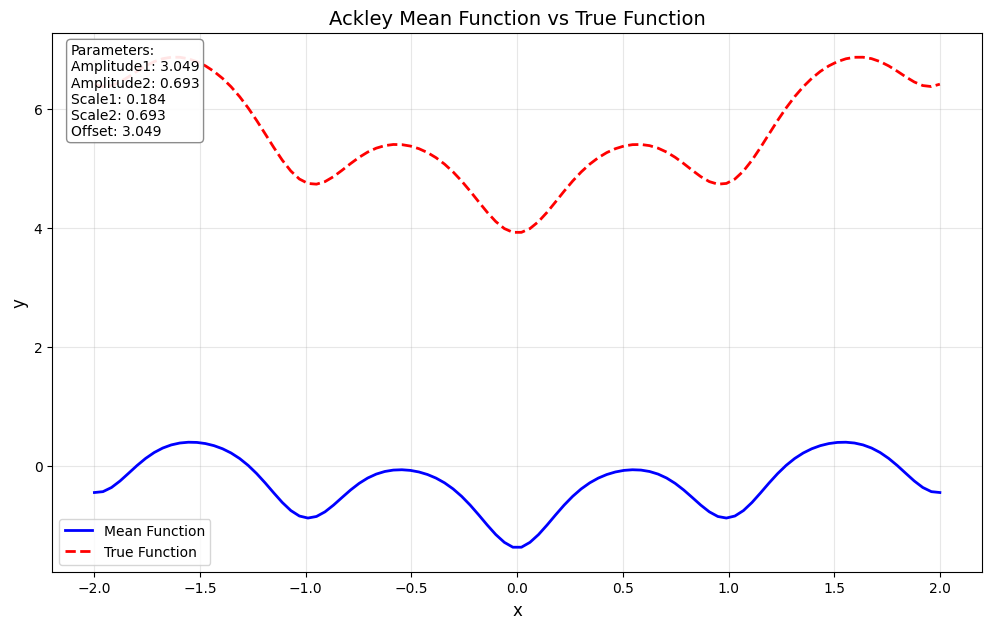

In [ ]:
class AckleyMean(gpytorch.means.Mean):
    def __init__(self, batch_shape=torch.Size()):
        super().__init__()

        # Register raw parameters with reasonable initial values
        self.register_parameter(
            name="raw_amplitude1",
            parameter=torch.nn.Parameter(torch.tensor(3.0))  # log(20)
        )
        self.register_parameter(
            name="raw_amplitude2",
            parameter=torch.nn.Parameter(torch.tensor(0.0))  # log(1)
        )
        self.register_parameter(
            name="raw_scale1",
            parameter=torch.nn.Parameter(torch.tensor(-1.6))  # log(0.2)
        )
        self.register_parameter(
            name="raw_scale2",
            parameter=torch.nn.Parameter(torch.tensor(0.0))  # log(1)
        )
        self.register_parameter(
            name="raw_offset",
            parameter=torch.nn.Parameter(torch.tensor(3.0))  # log(20)
        )

        # Register constraints for all parameters
        for param in ["raw_amplitude1", "raw_amplitude2", "raw_scale1", "raw_scale2", "raw_offset"]:
            self.register_constraint(param, Positive())

        # Register priors
        self.register_prior(
            "amplitude1_prior",
            LogNormalPrior(3.0, 0.5),
            lambda module: module.amplitude1,
            lambda module, value: module._set_amplitude1(value)
        )
        self.register_prior(
            "amplitude2_prior",
            LogNormalPrior(0.0, 0.5),
            lambda module: module.amplitude2,
            lambda module, value: module._set_amplitude2(value)
        )
        self.register_prior(
            "scale1_prior",
            LogNormalPrior(-1.6, 0.5),
            lambda module: module.scale1,
            lambda module, value: module._set_scale1(value)
        )
        self.register_prior(
            "scale2_prior",
            LogNormalPrior(0.0, 0.5),
            lambda module: module.scale2,
            lambda module, value: module._set_scale2(value)
        )
        self.register_prior(
            "offset_prior",
            LogNormalPrior(3.0, 0.5),
            lambda module: module.offset,
            lambda module, value: module._set_offset(value)
        )

    # Properties for transformed parameters
    @property
    def amplitude1(self):
        return self.raw_amplitude1_constraint.transform(self.raw_amplitude1)

    @property
    def amplitude2(self):
        return self.raw_amplitude2_constraint.transform(self.raw_amplitude2)

    @property
    def scale1(self):
        return self.raw_scale1_constraint.transform(self.raw_scale1)

    @property
    def scale2(self):
        return self.raw_scale2_constraint.transform(self.raw_scale2)

    @property
    def offset(self):
        return self.raw_offset_constraint.transform(self.raw_offset)

    # Setters for parameters
    def _set_amplitude1(self, value):
        if not torch.is_tensor(value):
            value = torch.tensor(value)
        self.initialize(raw_amplitude1=self.raw_amplitude1_constraint.inverse_transform(value))

    def _set_amplitude2(self, value):
        if not torch.is_tensor(value):
            value = torch.tensor(value)
        self.initialize(raw_amplitude2=self.raw_amplitude2_constraint.inverse_transform(value))

    def _set_scale1(self, value):
        if not torch.is_tensor(value):
            value = torch.tensor(value)
        self.initialize(raw_scale1=self.raw_scale1_constraint.inverse_transform(value))

    def _set_scale2(self, value):
        if not torch.is_tensor(value):
            value = torch.tensor(value)
        self.initialize(raw_scale2=self.raw_scale2_constraint.inverse_transform(value))

    def _set_offset(self, value):
        if not torch.is_tensor(value):
            value = torch.tensor(value)
        self.initialize(raw_offset=self.raw_offset_constraint.inverse_transform(value))

    def forward(self, x):
        if x.ndimension() == 1:
            x = x.unsqueeze(-1)

        # First exponential term (similar to original Ackley function)
        squared_sum = torch.sum(x**2, dim=-1)
        exp_term1 = -self.amplitude1 * torch.exp(-self.scale1 * torch.sqrt(squared_sum))

        # Second term capturing periodic behavior
        cos_term = torch.cos(2 * np.pi * x.squeeze(-1))
        exp_term2 = -self.amplitude2 * torch.exp(self.scale2 * cos_term)

        return exp_term1 + exp_term2 + self.offset

def plot_mean_function(mean_module, x_range=(-2, 2), n_points=100):
    """
    Plot the mean function over a specified range.

    Args:
        mean_module: The AckleyMean instance
        x_range: Tuple of (min_x, max_x)
        n_points: Number of points to evaluate
    """
    # Create evaluation points
    x = np.linspace(x_range[0], x_range[1], n_points)
    x_tensor = torch.tensor(x, dtype=torch.float64).reshape(-1, 1)

    # Evaluate mean function
    with torch.no_grad():
        mean_values = mean_module(x_tensor).numpy()

    # Create figure
    plt.figure(figsize=(12, 7))

    # Plot mean function
    plt.plot(x, mean_values, 'b-', label='Mean Function', linewidth=2)

    # Plot true function for comparison
    true_y = np.array([func(xi) for xi in x])
    plt.plot(x, true_y, 'r--', label='True Function', linewidth=2)

    # Add labels and title
    plt.xlabel('x', fontsize=12)
    plt.ylabel('y', fontsize=12)
    plt.title('Ackley Mean Function vs True Function', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    # Show parameter values
    param_text = 'Parameters:\n'
    param_text += f'Amplitude1: {mean_module.amplitude1.item():.3f}\n'
    param_text += f'Amplitude2: {mean_module.amplitude2.item():.3f}\n'
    param_text += f'Scale1: {mean_module.scale1.item():.3f}\n'
    param_text += f'Scale2: {mean_module.scale2.item():.3f}\n'
    param_text += f'Offset: {mean_module.offset.item():.3f}'

    # Add parameter text box
    plt.text(0.02, 0.98, param_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             fontsize=10,
             bbox=dict(boxstyle='round',
                      facecolor='white',
                      edgecolor='gray',
                      alpha=0.9))

    # # Add components plot
    # plt.figure(figsize=(12, 7))

    # # Evaluate individual components
    # with torch.no_grad():
    #     # First exponential term
    #     squared_sum = torch.sum(x_tensor**2, dim=-1)
    #     exp_term1 = -mean_module.amplitude1 * torch.exp(-mean_module.scale1 * torch.sqrt(squared_sum))

    #     # Second (periodic) term
    #     cos_term = torch.cos(2 * np.pi * x_tensor.squeeze(-1))
    #     exp_term2 = -mean_module.amplitude2 * torch.exp(mean_module.scale2 * cos_term)

    #     # Offset term
    #     offset = mean_module.offset * torch.ones_like(x_tensor.squeeze(-1))

    # # Plot components
    # plt.plot(x, exp_term1.numpy(), 'g-', label='Exponential Component', linewidth=2)
    # plt.plot(x, exp_term2.numpy(), 'm-', label='Periodic Component', linewidth=2)
    # plt.plot(x, offset.numpy() * np.ones_like(x), 'c-', label='Offset', linewidth=2)
    # plt.plot(x, mean_values, 'b-', label='Combined Mean Function', linewidth=2)
    # plt.plot(x, true_y, 'r--', label='True Function', linewidth=2)

    # plt.xlabel('x', fontsize=12)
    # plt.ylabel('y', fontsize=12)
    # plt.title('Mean Function Components', fontsize=14)
    # plt.legend(fontsize=10)
    # plt.grid(True, alpha=0.3)

    # plt.tight_layout()
    # plt.show()



# Create and plot mean function
mean_module = AckleyMean()
plot_mean_function(mean_module)
# plot_mean_evolution(mean_module, n_steps=5)


### 2b(ii). Define model

In [ ]:
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize, Normalize
# from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.kernels import  ScaleKernel

from gpytorch.constraints import GreaterThan

class CustomGP(SingleTaskGP):
    def __init__(self, train_X, train_Y, kernel, lengthscale_prior, outputscale_prior, noise_prior):
        super().__init__(
            train_X,
            train_Y,
            input_transform=Normalize(d=1),
            outcome_transform=Standardize(m=1)
        )

        # Replace default mean module with custom mean
        # self.mean_module = CustomMean()
        self.mean_module = AckleyMean()

        # Replace default kernel with custom kernel
        self.covar_module = ScaleKernel(kernel)

        # Register priors
        self.covar_module.base_kernel.register_prior(
            "lengthscale_prior",
            lengthscale_prior,
            lambda module: module.lengthscale,
            lambda module, value: module._set_lengthscale(value)
        )

        self.covar_module.register_prior(
            "outputscale_prior",
            outputscale_prior,
            lambda module: module.outputscale
        )

        self.likelihood.register_prior(
            "noise_prior",
            noise_prior,
            lambda module: module.noise
        )

        self.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))

### 2c(iii). Register kerne-priors

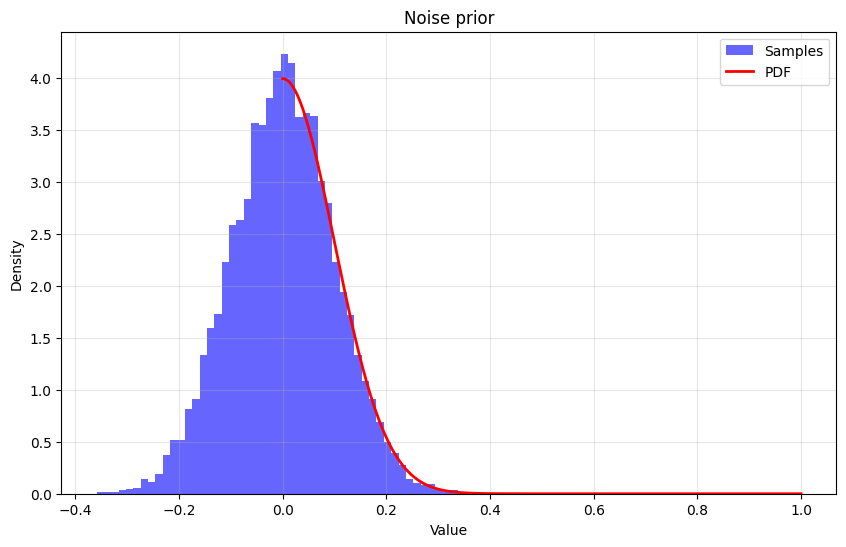

In [ ]:
### more kernel's to try
class RBFKernel(gpytorch.kernels.Kernel):
    is_stationary = True

    def __init__(self, variance_prior=None, length_prior=None,
                 variance_constraint=None, length_constraint=None, **kwargs):
        super().__init__(**kwargs)

        # Register raw parameters
        self.register_parameter(
            name='raw_lengthscale',  # Changed from raw_length to raw_lengthscale
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )
        self.register_parameter(
            name='raw_variance',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )

        # Set constraints
        if length_constraint is None:
            length_constraint = Positive()
        if variance_constraint is None:
            variance_constraint = Positive()

        self.register_constraint("raw_lengthscale", length_constraint)
        self.register_constraint("raw_variance", variance_constraint)

        # Set priors if any
        if length_prior is not None:
            self.register_prior(
                "lengthscale_prior",  # Changed from length_prior to lengthscale_prior
                length_prior,
                lambda m: m.lengthscale,  # Changed from length to lengthscale
                lambda m, v: m._set_lengthscale(v),  # Changed from _set_length
            )
        if variance_prior is not None:
            self.register_prior(
                "variance_prior",
                variance_prior,
                lambda m: m.variance,
                lambda m, v: m._set_variance(v),
            )

    # Lengthscale property
    @property
    def lengthscale(self):  # Changed from length to lengthscale
        return self.raw_lengthscale_constraint.transform(self.raw_lengthscale)

    @lengthscale.setter
    def lengthscale(self, value):
        return self._set_lengthscale(value)

    def _set_lengthscale(self, value):  # Changed from _set_length
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_lengthscale)
        self.initialize(raw_lengthscale=self.raw_lengthscale_constraint.inverse_transform(value))

    # Variance property
    @property
    def variance(self):
        return self.raw_variance_constraint.transform(self.raw_variance)

    @variance.setter
    def variance(self, value):
        return self._set_variance(value)

    def _set_variance(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_variance)
        self.initialize(raw_variance=self.raw_variance_constraint.inverse_transform(value))

    def forward(self, x1, x2, **params):
        dist = self.covar_dist(x1, x2, **params)
        scaled_dist = dist.div(self.lengthscale)
        return self.variance * torch.exp(-0.5 * scaled_dist.pow(2))

class Matern52Kernel(gpytorch.kernels.Kernel):
    is_stationary = True

    def __init__(self, variance_prior=None, length_prior=None,
                 variance_constraint=None, length_constraint=None, **kwargs):
        super().__init__(**kwargs)

        # Register raw parameters
        self.register_parameter(
            name='raw_lengthscale',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )
        self.register_parameter(
            name='raw_variance',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )

        # Set constraints
        if length_constraint is None:
            length_constraint = Positive()
        if variance_constraint is None:
            variance_constraint = Positive()

        self.register_constraint("raw_lengthscale", length_constraint)
        self.register_constraint("raw_variance", variance_constraint)

        # Set priors if any
        if length_prior is not None:
            self.register_prior(
                "lengthscale_prior",
                length_prior,
                lambda m: m.lengthscale,
                lambda m, v: m._set_lengthscale(v),
            )
        if variance_prior is not None:
            self.register_prior(
                "variance_prior",
                variance_prior,
                lambda m: m.variance,
                lambda m, v: m._set_variance(v),
            )

    # Lengthscale property
    @property
    def lengthscale(self):
        return self.raw_lengthscale_constraint.transform(self.raw_lengthscale)

    @lengthscale.setter
    def lengthscale(self, value):
        return self._set_lengthscale(value)

    def _set_lengthscale(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_lengthscale)
        self.initialize(raw_lengthscale=self.raw_lengthscale_constraint.inverse_transform(value))

    # Variance property
    @property
    def variance(self):
        return self.raw_variance_constraint.transform(self.raw_variance)

    @variance.setter
    def variance(self, value):
        return self._set_variance(value)

    def _set_variance(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_variance)
        self.initialize(raw_variance=self.raw_variance_constraint.inverse_transform(value))

    def forward(self, x1, x2, **params):
        dist = self.covar_dist(x1, x2, **params)
        scaled_dist = dist.div(self.lengthscale)

        # Matern 5/2 formula
        sqrt_5 = math.sqrt(5.0)
        scaled_dist_5_3 = scaled_dist * sqrt_5

        return self.variance * (1.0 + scaled_dist_5_3 + (5.0/3.0) * scaled_dist.pow(2)) * \
               torch.exp(-scaled_dist_5_3)

class PeriodicKernel(gpytorch.kernels.Kernel):
    is_stationary = True

    def __init__(self, period_prior=None, length_prior=None, variance_prior=None,
                 period_constraint=None, length_constraint=None, variance_constraint=None, **kwargs):
        super().__init__(**kwargs)

        # Register raw parameters
        self.register_parameter(
            name='raw_period',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )
        self.register_parameter(
            name='raw_lengthscale',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )
        self.register_parameter(
            name='raw_variance',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )

        # Set constraints
        if period_constraint is None:
            period_constraint = Positive()
        if length_constraint is None:
            length_constraint = Positive()
        if variance_constraint is None:
            variance_constraint = Positive()

        self.register_constraint("raw_period", period_constraint)
        self.register_constraint("raw_lengthscale", length_constraint)
        self.register_constraint("raw_variance", variance_constraint)

        # Set priors if any
        if period_prior is not None:
            self.register_prior(
                "period_prior",
                period_prior,
                lambda m: m.period,
                lambda m, v: m._set_period(v),
            )
        if length_prior is not None:
            self.register_prior(
                "lengthscale_prior",
                length_prior,
                lambda m: m.lengthscale,
                lambda m, v: m._set_lengthscale(v),
            )
        if variance_prior is not None:
            self.register_prior(
                "variance_prior",
                variance_prior,
                lambda m: m.variance,
                lambda m, v: m._set_variance(v),
            )

    # Period property
    @property
    def period(self):
        return self.raw_period_constraint.transform(self.raw_period)

    @period.setter
    def period(self, value):
        return self._set_period(value)

    def _set_period(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_period)
        self.initialize(raw_period=self.raw_period_constraint.inverse_transform(value))

    # Lengthscale property
    @property
    def lengthscale(self):
        return self.raw_lengthscale_constraint.transform(self.raw_lengthscale)

    @lengthscale.setter
    def lengthscale(self, value):
        return self._set_lengthscale(value)

    def _set_lengthscale(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_lengthscale)
        self.initialize(raw_lengthscale=self.raw_lengthscale_constraint.inverse_transform(value))

    # Variance property
    @property
    def variance(self):
        return self.raw_variance_constraint.transform(self.raw_variance)

    @variance.setter
    def variance(self, value):
        return self._set_variance(value)

    def _set_variance(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_variance)
        self.initialize(raw_variance=self.raw_variance_constraint.inverse_transform(value))

    def forward(self, x1, x2, **params):
        dist = self.covar_dist(x1, x2, **params)
        # Periodic kernel formula: k(x,x') = σ² * exp(-2 * sin²(π|x-x'|/p) / ℓ²)
        scaled_sin = torch.sin(math.pi * dist / self.period)
        exp_term = -2 * (scaled_sin ** 2) / (self.lengthscale ** 2)
        return self.variance * torch.exp(exp_term)



## define priors
from gpytorch.priors import GammaPrior, NormalPrior
from gpytorch.priors import UniformPrior, LogNormalPrior, HalfNormalPrior, NormalPrior
from gpytorch.constraints import Interval

lengthscale_prior = UniformPrior(0.10, 0.5)# length scale in RBF kernel
outputscale_prior = LogNormalPrior(0, 1)# Variance in RBF kernel
# noise_prior = HalfNormalPrior(0.01, 1)
noise_prior = NormalPrior(0, 0.1)
length_constraint = Interval(0.10, 0.5)  # Matching constraint to lengthscale_prior distribution support , kernel length often need constraints (e.g., positive values) -

# kernel = RBFKernel(length_prior=lengthscale_prior,
#                    length_constraint=length_constraint
#                    )
kernel = Matern52Kernel(length_prior=lengthscale_prior,
                   length_constraint=length_constraint
                   )
# kernel = PeriodicKernel(length_prior=lengthscale_prior,
#                    length_constraint=length_constraint
#                    )

## more priors: GammaPrior, HalfCauchyPrior, LKJCovariancePrior, MultivariateNormalPrior, NormalPrior, SmoothedBoxPrior, UniformPrior, LogNormalPrior

# Generate samples
num_samples = 10000
samples = noise_prior.sample(torch.Size([num_samples]))

# Create the plot
plt.figure(figsize=(10, 6))

# Histogram of samples
plt.hist(samples.numpy(), bins=50, density=True, alpha=0.6, color='blue', label='Samples')

# Generate points for the PDF
x = np.linspace(0, 1, 1000)
pdf = noise_prior.log_prob(torch.tensor(x)).exp()
plt.plot(x, pdf, 'r-', lw=2, label='PDF')

plt.title('Noise prior')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 2d(iv). Active learning

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))
/tmp/ipython-input-22-1492585536.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(measure(X, noise=0), dtype=torch.double)



Lengthscale:
  Value: 0.115
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


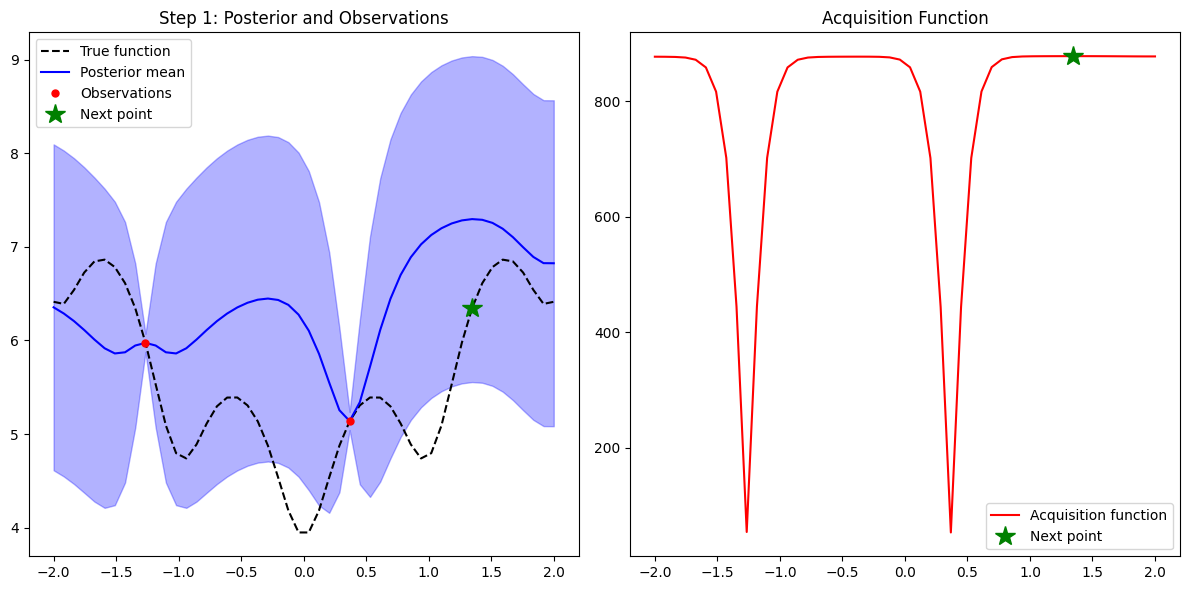

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.100
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


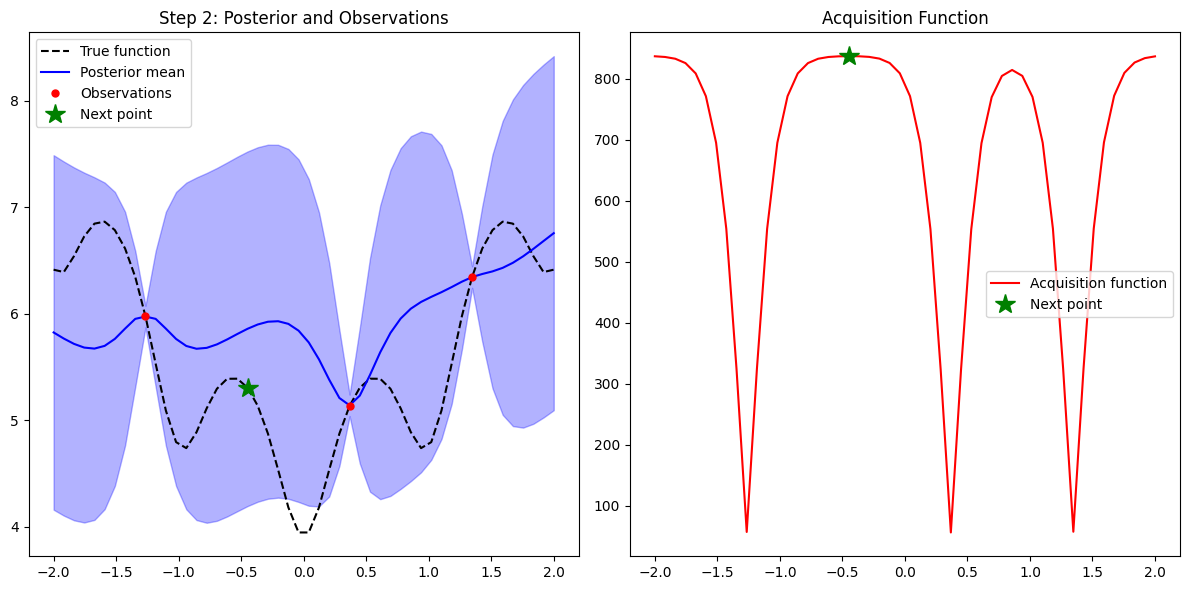

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.100
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


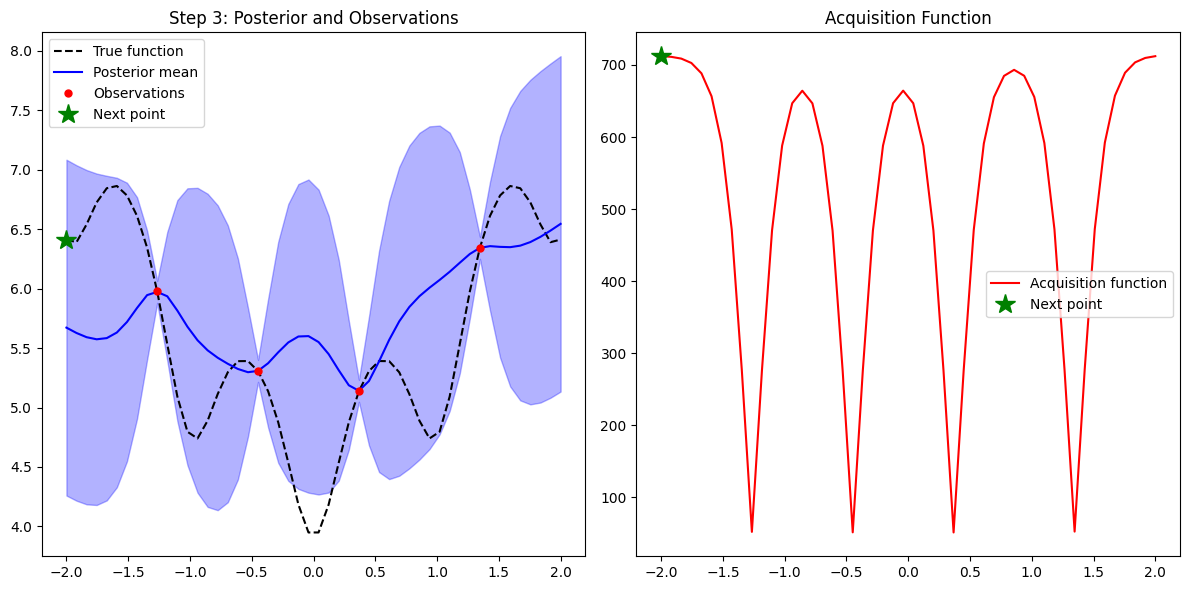

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.100
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


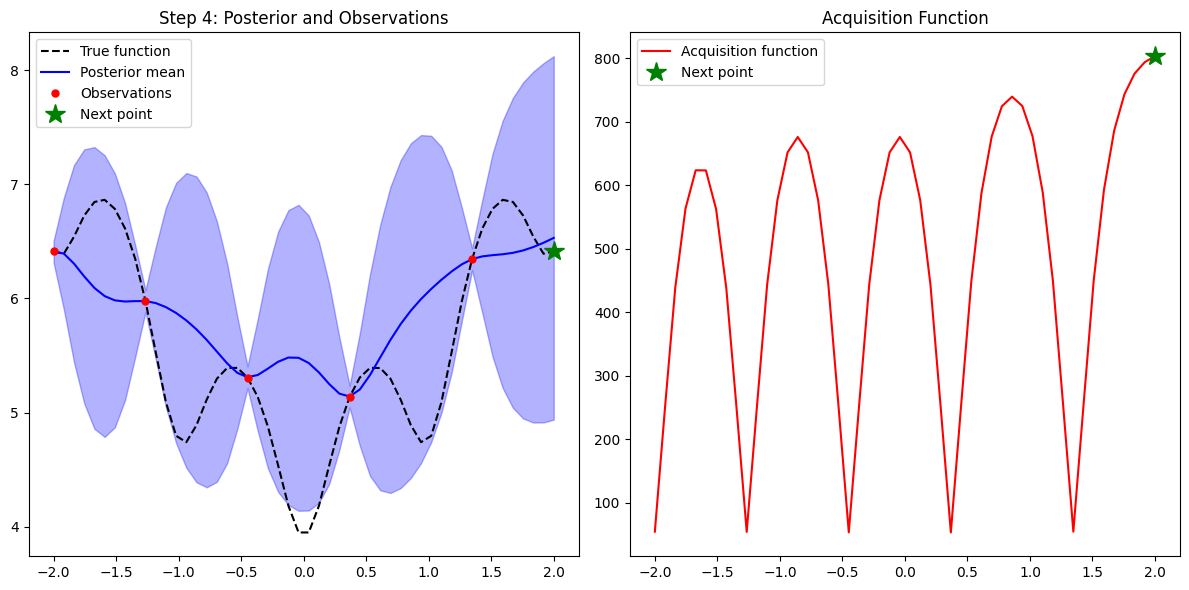

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.100
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


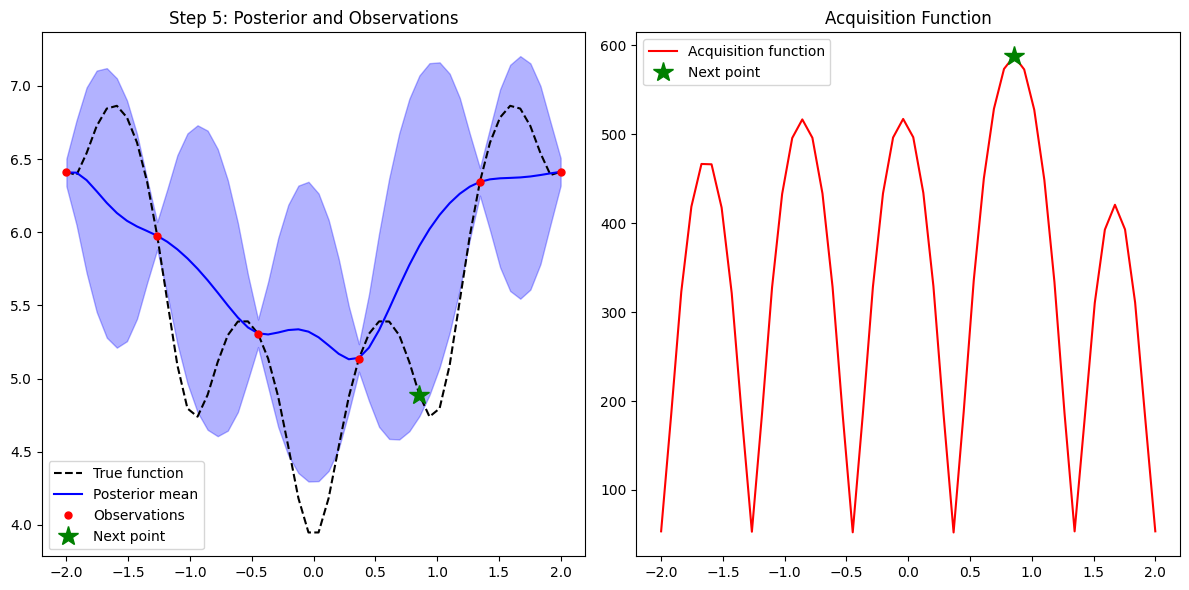

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.100
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


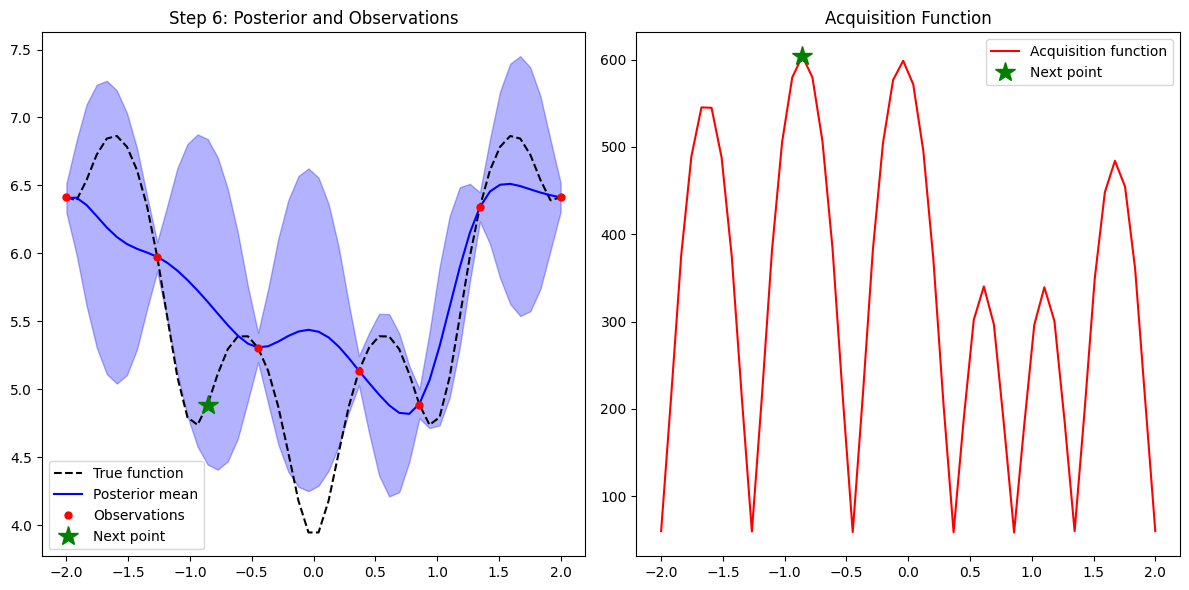

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.100
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


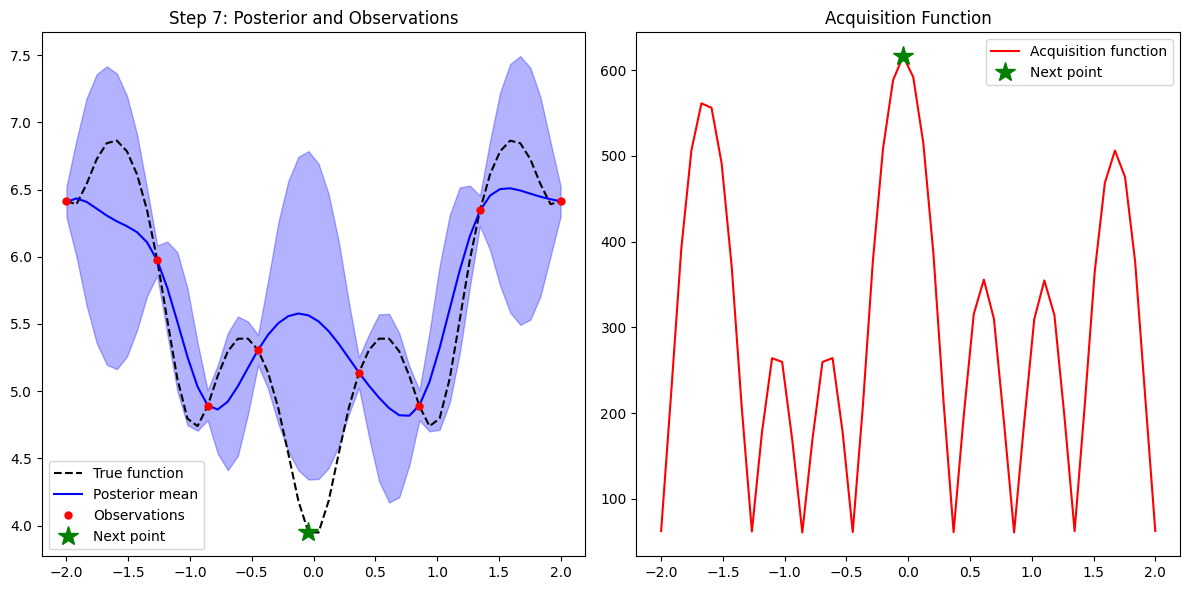

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.100
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


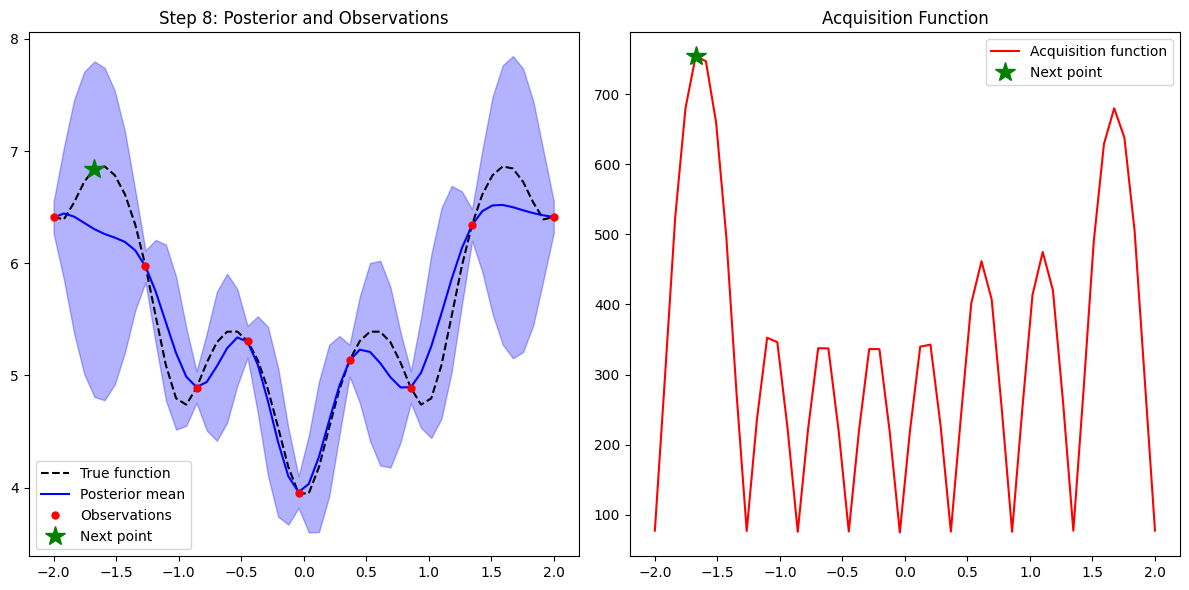

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.100
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


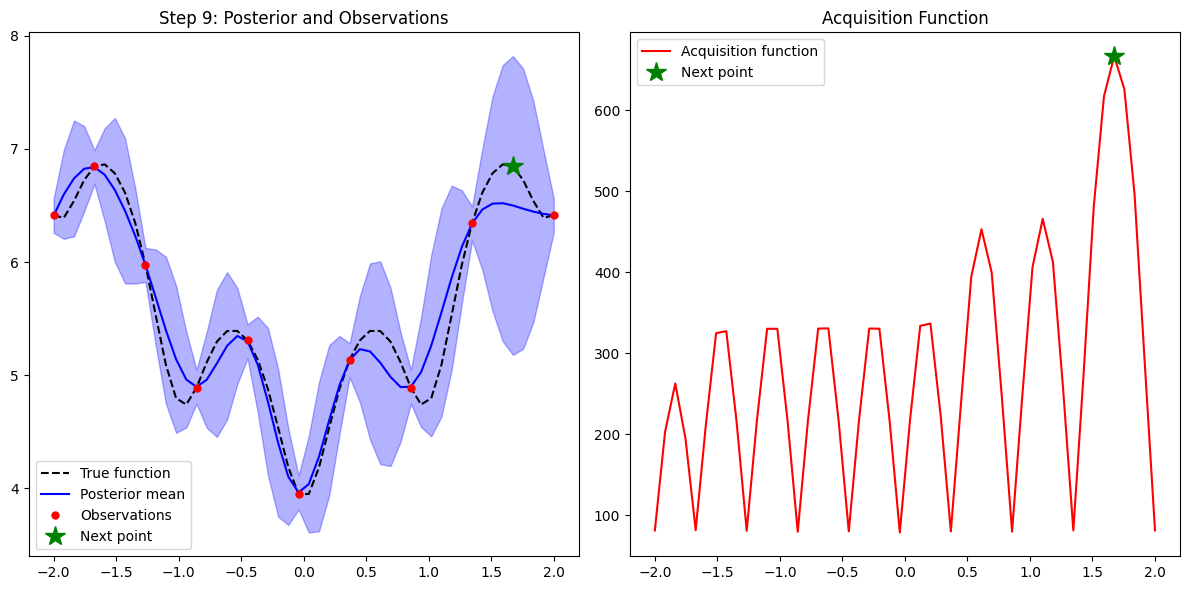

/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))



Lengthscale:
  Value: 0.100
  Prior mean: 0.300
  Prior std: 0.115

Outputscale:
  Value: 0.368
  Prior mean: 1.649
  Prior std: 2.161

Noise:
  Value: 0.007
  Prior mean: 0.000
  Prior std: 0.100


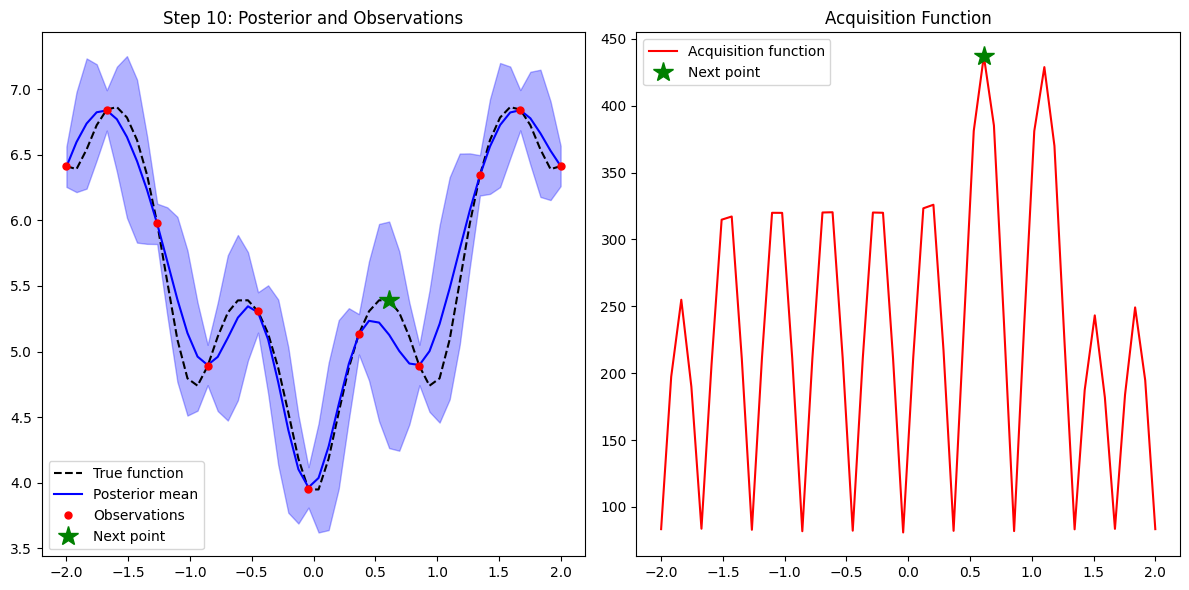


Optimization completed!
Best observed value: 3.949
At location: -0.041


/tmp/ipython-input-6-2316112792.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
/tmp/ipython-input-6-2316112792.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))


In [ ]:
# Create discrete grid
x_points = torch.linspace(-2, 2, 50, dtype=torch.double)
discrete_points = x_points.unsqueeze(-1)

# Initial training data
n_train = 2
train_indices = torch.randperm(len(discrete_points))[:n_train]
X = discrete_points[train_indices]
# y = torch.tensor(measure(X), dtype=torch.double)
y = torch.tensor(measure(X, noise=0), dtype=torch.double)


n_iterations = 10
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf_discrete
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import UpperConfidenceBound
from torch.optim import Adam


for step in range(n_iterations):
    # Fit GP
    model = CustomGP(X, y, kernel, lengthscale_prior, outputscale_prior, noise_prior)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    print_detailed_model_parameters(model)


    # Define acquisition function
    # EI = ExpectedImprovement(model=model, best_f=y.min())
    # UCB = UpperConfidenceBound(model=model, beta=0)  # beta controls exploration vs exploitation
    # Define acquisition function
    acq_func = UpperConfidenceBound(model=model, beta = 1e6 ) #--> higher beta maximum uncertanity
    # Get remaining points (exclude training points)
    mask = torch.ones(len(discrete_points), dtype=torch.bool)
    mask[train_indices] = False
    available_points = discrete_points[mask]

    # Optimize acquisition function discretely
    candidate, acq_value = optimize_acqf_discrete(
        acq_function=acq_func,
        q=1,
        choices=available_points,
        unique=True,
    )

    # Plot
    plot_step(model, X, y, candidate, acq_func, discrete_points, step + 1)

    # Update data
    X = torch.cat([X, candidate])
    y_new = torch.tensor([[measure(candidate.item(), noise=0)]], dtype=torch.double)

    y = torch.cat([y, y_new])

    # Update training indices
    new_idx = torch.where((discrete_points == candidate).all(dim=1))[0]
    train_indices = torch.cat([train_indices, new_idx])

print("\nOptimization completed!")
print(f"Best observed value: {y.min().detach().item():.3f}")
print(f"At location: {X[y.argmin()].detach().item():.3f}")
